In [1]:
import pandas as pd
import numpy as np
import openai
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from ast import literal_eval
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from openai import AzureOpenAI 
from getpass import getpass

api_base = getpass("AZURE_OPENAI_ENDPOINT")
api_key= getpass("AZURE_OPENAI_API_KEY")


AZURE_OPENAI_ENDPOINT········
AZURE_OPENAI_API_KEY········


In [55]:
label_names = [
    'ARBEIT.', 'BILDUNG.', 'ENERGIE.', 'FREIZEIT.', 'GESCHICHTE.',
    'GESUNDHEIT.', 'GEWERBE.', 'INDUSTRIE.', 'JUSTIZ.', 'KULTUR.',
    'LANDWIRTSCHAFT.', 'MEDIEN UND KOMMUNIKATION.', 'MENSCH.', 'MILITÄR.',
    'PORTRÄT.', 'RELIGION.', 'SENSATION.', 'SOZIALES.',
    'STAAT UND POLITIK.', 'STRAFTAT.', 'TECHNIK.', 'UMWELT.', 'VERKEHR.',
    'VOLKSKULTUR.', 'WIRTSCHAFT.', 'WISSENSCHAFT.'
]
len(label_names)

26

In [87]:
# df_full = pd.read_excel('../Datenlieferung FARO/Tabelle_Level1und2.xlsx')
# df_full
df_sub = pd.read_excel('../Datenlieferung FARO/Tabelle_Level1und2.xlsx', sheet_name=1).loc[:0, :].set_index('Bezeichnung')
markdown_table = df_sub.to_markdown()


In [5]:
# Load and preprocess dataset
df = pd.read_pickle('../Daten/FINAL_faro_cleaned_balanced.pkl')#.sample(10000)   


# Convert stringified lists to actual lists
if type(df['Categories'][0])!=list:
    print('Convert Categories to list ...')
    df['Categories'] = df['Categories'].apply(literal_eval)  

# if type(df['web_embeddings'][0])!=list:
#     print('Convert Embeddings to list ...')
#     df['web_embeddings'] = df['web_embeddings'].apply(literal_eval)     
    

# Sample 300 to test Prompts
df_sample_ = df.sample(300, random_state=42)

In [6]:
df.shape

(32799, 30)

In [7]:
# Feature list
X = df['Web-Text']
# Label list 
y = df['Categories'].tolist()  

In [8]:
# First split: Separate out the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Separate the remaining data into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Convert to numpy arrays
X_train = np.array(X_train)
#X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
#y_val = np.array(y_val)
y_test = np.array(y_test)

In [9]:
X_train.shape

(26239,)

In [10]:
X_test.shape

(6560,)

In [11]:
y_train.shape

(26239, 26)

In [12]:
y_test.shape

(6560, 26)

In [13]:
# Detect Non-German Texts
# from langdetect import detect_langs
# from tqdm import tqdm
# tqdm.pandas()

# def detect_language_with_langdetect(line): 
#     try: 
#         langs = detect_langs(line) 
#         for item in langs: # The first one returned is the one that has the highest probability
#             return item.lang, item.prob 
#     except: 
#         return "err", 0.0 
    
# df['lang'] = df['Web-Text'].progress_apply(detect_language_with_langdetect)
# df['lang'], df['lang_prob'] = df['lang'].str[0], df['lang'].str[1]

## Test Chat GPT Prompts

In [95]:
import re

def match_and_encode_tags(output, real_tags):
    real_tags = [tag.replace('.', '') for tag in real_tags]
    
    # Define the regex pattern to capture tags with and without trailing dots
    tag_pattern = re.compile(r'\b(' + '|'.join(real_tags) + r')\.?\b', re.IGNORECASE)
    
    # Extract tags from the output
    matched_tags = tag_pattern.findall(output)
    
    # Normalize matched tags by converting them to uppercase and removing trailing dots
    matched_tags = [tag.upper().replace('.', '') for tag in matched_tags]

    # Check if matched_tags are valid, otherwise set all values to zero
    if not matched_tags or any(tag not in real_tags for tag in matched_tags):
        one_hot_encoded = [0] * len(real_tags)
    else:
        # Initialize a one-hot encoded list
        one_hot_encoded = [1 if tag in matched_tags else 0 for tag in real_tags]

    return one_hot_encoded

In [96]:
def visualisation_encodings(response, test_text, df_text):
    
    # The regex pattern
    pattern = r"^\['[A-ZÄÖÜẞ\s]+\.'(\s*,\s*'[A-ZÄÖÜẞ\s]+\.')?\]$"

    print(f'Text: {test_text}')
    # Check each string against the regex
    if re.match(pattern, response.choices[0].message.content):
        print(f"Output Tags (correct format): {response.choices[0].message.content}")
    else:
        print(f"Output Tags (incorrect format): {response.choices[0].message.content}")
        
    # Finding indexes where the value is 1
    print(f'Real Tags: {df_text.columns[df_text.loc[0] == 1].tolist()}')
    print('')
    

In [97]:
def hamming_accuracy(actuals, predictions):
    return (actuals == predictions).mean()

In [98]:
deployment_name = 'gpt-35-turbo' 
#deployment_name = 'gpt-4-preview'
api_version = '2023-12-01-preview' # this might change in the future
client = AzureOpenAI( api_key=api_key, api_version=api_version, base_url=f"{api_base}/openai/deployments/{deployment_name}" )

## Prompt 0: Tags Only Table (Description AND Keywords)

In [29]:
from tqdm.notebook import tqdm
prompt_0_accuracy = []
prompt_0_targets = []
prompt_0_outputs = []

import time
start = time.time()

counter = 0
for test_text in tqdm(df_sample_['Web-Text']):
    prompt = f"""
                Bitte klassifizieren Sie den folgenden Text, indem Sie bis zu zwei relevante Tags aus der bereitgestellten 
                Liste zuweisen. Wählen Sie ein Tag, wenn es eindeutig am relevantesten ist, oder zwei, wenn zwei Themen 
                gleichermaßen prominent sind. Die Tags sollten die Hauptthemen des Textes widerspiegeln und mit den 
                Inhalten des öffentlich-rechtlichen Rundfunks übereinstimmen.

                Die Tags sind:
                - ARBEIT.
                - BILDUNG.
                - ENERGIE.
                - FREIZEIT.
                - GESCHICHTE.
                - GESUNDHEIT.
                - GEWERBE.
                - INDUSTRIE.
                - JUSTIZ.
                - KULTUR.
                - LANDWIRTSCHAFT.
                - MEDIEN UND KOMMUNIKATION.
                - MENSCH.
                - MILITÄR.
                - PORTRÄT.
                - RELIGION.
                - SENSATION.
                - SOZIALES.
                - STAAT UND POLITIK.
                - STRAFTAT.
                - TECHNIK.
                - UMWELT.
                - VERKEHR.
                - VOLKSKULTUR.
                - WIRTSCHAFT.
                - WISSENSCHAFT.

                Text zum Klassifizieren: '{test_text}'

                Geben Sie nur die Tags als Python-Liste aus.
            """

    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "Sie sind ein hilfreicher Assistent, der dem Redaktionsteam des öffentlich-rechtlichen Rundfunks hilft, zentrale Themen aus beschreibenden Videotexten zu extrahieren."},
                {"role": "user", "content": prompt}
            ]
        )
    except Exception as e:
        continue
        print(f"API Error: {test_text}, Error: {e}")
    
     # Transfer ChatGPT output to One-Hot encoded list
    try:
        output_tags = response.choices[0].message.content
        one_hot_encoded_tags = match_and_encode_tags(output_tags, label_names)
        df_text = df[df['Web-Text'] == test_text].reset_index(drop=True)   
    except Exception as e:
        print(f"Error processing text:{e}")
        print(response.choices[0].message.content)
        continue
    
    prompt_0_outputs.append(one_hot_encoded_tags)
    prompt_0_targets.append(df_text['Categories'][0])    
    # Compute Accuracy on the fly
    match_percent = sum(i==j for i,j in zip(df_text['Categories'][0],one_hot_encoded_tags))/len(one_hot_encoded_tags)
    prompt_0_accuracy.append(match_percent)
    
    # Print some of the Answers
    if counter % 15 == 0:
        # Show the Answer
        visualisation_encodings(response, test_text, df_text)
    
    counter += 1
    
end = time.time()
print(end - start)

  0%|          | 0/300 [00:00<?, ?it/s]

Text: Türkei stimmt für Schwedens Nato-Beitritt
Das türkische Parlament hat den Beitritt Schwedens in die Nato gebilligt. Nun muss Präsident Erdogan das sogenannte Beitrittsprotokoll noch unterschreiben, was als so gut wie sicher gilt.
Output Tags (incorrect format): ['STAAT UND POLITIK']
Real Tags: ['MILITÄR.']

Text: Wie funktionieren Wetten?
In einem Beitrag werden die diversen möglichen Wetten aufgezeigt, die auf jedes Spiel eingegangen werden können. Zudem wird klar, dass man auf irgendein Spiel setzen kann  ganz egal, wo es stattfindet. Roger Hegi betont, dass Wetten auf die manipulierten Schweizer Spiele vor allem in Asien platziert wurden. Markus Stähli begründet, wieso alle Thuner Spieler eine Erklärung unterschreiben mussten, dass sie nicht betrogen haben.
Output Tags (incorrect format): ['FREIZEIT', 'SPORT']
Real Tags: ['FREIZEIT.', 'MEDIEN UND KOMMUNIKATION.', 'STRAFTAT.']

Text: Langlauf und Tourenskifahren sind die besten Kalorien-Killer
Die Hauptmotivation von Winterspo

628.8021972179413


In [30]:
np.mean(prompt_0_accuracy)
# prompt_0_targets
# prompt_0_outputs

0.9283686112545174

In [31]:
hamming_accuracy(np.array(prompt_0_targets),np.array(prompt_0_outputs))

0.9283686112545173

In [64]:
from sklearn.metrics import classification_report

report = classification_report(prompt_0_targets, prompt_0_outputs, target_names=label_names)
print(report)

                           precision    recall  f1-score   support

                  ARBEIT.       0.30      0.50      0.37        12
                 BILDUNG.       0.38      0.67      0.48         9
                 ENERGIE.       1.00      0.74      0.85        19
                FREIZEIT.       0.52      0.46      0.49        24
              GESCHICHTE.       0.21      0.80      0.33        10
              GESUNDHEIT.       0.80      0.67      0.73        36
                 GEWERBE.       0.42      0.17      0.24        29
               INDUSTRIE.       1.00      0.12      0.21        17
                  JUSTIZ.       0.60      0.52      0.56        23
                  KULTUR.       0.68      0.66      0.67        35
          LANDWIRTSCHAFT.       0.83      0.40      0.54        25
MEDIEN UND KOMMUNIKATION.       0.43      0.48      0.45        25
                  MENSCH.       0.33      0.11      0.17        27
                 MILITÄR.       0.83      0.53      0.65     

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
results_0 = list(precision_recall_fscore_support(prompt_0_targets, prompt_0_outputs, average='samples'))
results_0.append(hamming_accuracy(np.array(prompt_0_targets),np.array(prompt_0_outputs)))
results_0

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5822147651006712,
 0.45665548098434006,
 0.4840044742729307,
 None,
 0.9283686112545173]

In [67]:
# from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(prompt_0_targets, prompt_0_outputs, average='samples')

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5822147651006712, 0.45665548098434006, 0.4840044742729307, None)

In [75]:
# from sklearn.metrics import average_precision_score
# average_precision_score(prompt_0_targets, prompt_0_outputs)

# from sklearn.metrics import hamming_loss
# 1 - hamming_loss(prompt_0_targets, prompt_0_outputs)


# from sklearn.metrics import jaccard_score
# jaccard_score(prompt_0_targets, prompt_0_outputs, average='samples')

In [ ]:
prompt = f"""
            Angesichts der folgenden beschreibenden Webtexte, die verschiedene Arten von Videos beschreiben, 
            die von Schweizer Radio und Fernsehen veröffentlicht werden, klassifizieren Sie bitte jeden Ausschnitt, 
            indem Sie bis zu zwei relevante Tags aus der bereitgestellten Tag-Liste zuweisen. 
            Wählen Sie ein Tag, wenn es eindeutig am relevantesten ist, oder zwei Tags, 
            wenn zwei Themen gleichermaßen prominent sind. 
            Die Tags sollten die Hauptthemen des Textes genau widerspiegeln 
            und zum Portfolio eines öffentlich-rechtlichen Senders passen.

            Die Tags und ihre zugehörigen Themen und Schlüsselwörter sind in der folgenden Tabelle beschrieben:

            | Tag | Beschreibung | Schlüsselwörter |
            |:---|:------------|:----------------|
            | ARBEIT. | Was sich auf den Arbeitsbereich aus Sicht von Arbeitnehmern und Gewerkschaften bezieht (nicht Politik). Beinhaltet Arbeitsbedingungen, Arbeitskonflikte, Arbeitslosigkeit, Arbeitsmarkt, Karrieren und Pensionierung. Schließt Arbeitgeber, Unternehmen und bildungsbezogene Themen aus. | Arbeit, Arbeitnehmer, Arbeitsbedingung, Arbeitsrecht, Arbeitskonflikt, Arbeitslosigkeit, Arbeitsmarkt, Arbeitsvermittlung, Beruf, Einkommen, Gastarbeiter, Heimarbeit, Kinderarbeit, Karriere, Pensionierung, Schwarzarbeit, Sozialpartnerschaft |
            | BILDUNG. | Öffentliche und elterliche Erziehung bis zur Erfüllung der Schulpflicht, einschließlich aller Schulstufen, Hochschulbildung und betriebsinterne Weiterbildung. Schließt reine Freizeitbildung wie Gartenbaukurse aus. | Berufsbildung, Bildung, Eltern, Erwachsenenbildung, Erziehung, Hochschule, Höhere Fachschule, Fachmittelschule, Gymnasium, Kindergarten, Lehrer, Heil- und Sonderpädagogik, Primarschule, Privatschule, Schule, Schüler, Schulinhalt, Schulreform, Sekundarschule, Stipendium, Sportschule, Studierende |
            | ENERGIE. | Bezieht sich auf Energieträger, Ressourcen, Produktion, Verteilung, Verbrauch und energiepolitische Themen (nicht Politik). Schließt Umweltschäden und Atomwaffen aus. | Atomenergie, Brennstoff, Elektrizität, Energie, Energieverbrauch, Energietransport, Energiespeicher, Energiepolitik, Erneuerbare Energie, Fossile Energie, Kraftwerk, Staudamm |
            | FREIZEIT. | Nicht-professionelle Freizeitaktivitäten, Breitensport. Schließt arbeitsbezogene Bildung und alle professionellen Sportarten aus. | Alpinismus, Badeanstalt, Breitensport, Denksport, Ferien, Freizeit, Freizeitgarten, Freizeittanz, Geselligkeit, Glücksspiel, Hobby, Jahrmarkt, Nachtleben, Spielen, Sportanlage, Sportgerät, Tourismus, Verein, Wandern |
            | GESCHICHTE. | Historische Ereignisse und Epochen. Schließt Geschichtswissenschaft und Baugeschichte aus. | Geschichte, Geschichte-Früheste, Geschichte-Alte, Geschichte-Mittelalter, Geschichte-Neuere, Geschichte-Neueste |
            | GESUNDHEIT. | Themen rund um Gesundheit und Krankheit; Geburt; Patientenrechte (nicht Justiz); Rettungsdienste (nicht Verkehr); medizinische Forschung (nicht Wissenschaft); Sportmedizin (nicht Sport). Schließt Sterben aus. | Alternativmedizin, Arzt, Drogenpolitik, Ernährung, Gesundheit, Gesundheitswesen, Hygiene, Krankenversicherung, Krankheit, Kur, Medikament, Medizin, Medizinische Forschung, Patientenrecht, Psychiatrie, Rettungswesen, Schwangerschaft, Sucht, Zahnmedizin |
            | GEWERBE. | Kleine und mittlere Unternehmen ohne klare Abgrenzung zur Industrie, basierend auf der Allgemeinen Systematik der Wirtschaftszweige (NOGA). Schließt Industrie und Kultur aus. | Autogewerbe, Baugewerbe, Detailhandel, Dienstleistung, Gartenbau, Gastgewerbe, Getränk, Gewerbe, Handwerk, Haustechnik, Immobilienhandel, Kochen, Lebensmittelbranche, Logistik, Möbelbranche, Reiseunternehmen, Sicherheitsbranche |
            | INDUSTRIE. | Industrielle Produktion ohne klare Abgrenzung zum Handel, basierend auf NOGA. Schließt alle arbeitsbezogenen Themen aus. | Autoindustrie, Bergbau, Chemieindustrie, Computerindustrie, Druckindustrie, Flugzeugindustrie, Industrie, Industriestandort, Maschinenindustrie, Metallindustrie, Papierindustrie, Pharmaindustrie, Rohstoff, Rüstungsindustrie, Schiffsbau, Schuhindustrie, Sportartikelindustrie, Tabakindustrie, Textilindustrie, Uhrenindustrie, Unterhaltungselektronik |
            | JUSTIZ. | Rechtliche Angelegenheiten: Justiz, Gesetze, Rechtsprechung, internationales Recht (nicht Politik). Schließt Verbrechen, Polizei, Militärjustiz aus. | Bürgerrecht, Eigentumsrecht, Gericht, Gesetz, Internationales Recht, Justiz, Meinungsfreiheit, Menschenrecht, Ombudsstelle, Persönlichkeitsschutz, Personendokument, Strafrecht, Strafverfahren, Strafvollzug, Strafvollzugsanstalt, Urheberrecht, Wettbewerbsrecht, Zivilrecht |
            | KULTUR. | Kulturelle Aktivitäten und künstlerische Schöpfung; Kino, Bibliotheken, Archive (nicht Medien). Schließt Medien, Volkskultur aus. | Architektur, Ausstellung, Denkmal, Design, Film, Fotografie, Gedächtnisinstitution, Kino, Kultur, Kulturpolitik, Kulturförderung, Kulturzentrum, Kunst, Literatur, Mode, Musik, Sprache und Schrift, Tanz, Theater, Unterhaltungsbranche |
            | LANDWIRTSCHAFT. | Landwirtschaftliche Produktion; Fischerei; Forstwirtschaft; Jagd; Pflanzen; Tiere; Veterinärmedizin. Schließt Umweltprobleme und den Vertrieb/Verkauf landwirtschaftlicher Produkte aus. | Agrarpolitik, Berglandwirtschaft, Biologische Landwirtschaft, Fischerei, Fleischproduktion, Forstwirtschaft, Jagd, Landwirtschaft, Landwirtschaftsprodukt, Milch, Nutzpflanze, Tierhaltung, Veterinärmedizin, Weinbau |
            | MEDIEN UND KOMMUNIKATION. | Presse, Bücher, TV, Radio, Video, neue (soziale) Medien; Nachrichtenagenturen (nicht Wirtschaft); Post (nicht Wirtschaft, nicht Staat). Schließt Kultur, Literatur, Musik aus. | Fernsehen, Internet, Journalismus, Medien, Medien und Kommunikation, Medien- und Multimedia-Unternehmen, Medienpolitik, Nachrichtenagentur, Post, Presse, Radio, Satellitenkommunikation, Telekommunikation, Verlag, Video, Zensur |
            | MENSCH. | Soziale Gruppen nach Alter, Geschlecht, Status oder Orientierung; Minderheiten; Wohnen. Schließt Sozialwesen, politische Gruppen, religiöse Gruppen, Kinder und Jugendliche aus. | Alltag, Alter, Asylpolitik, Ausländer, Auslandschweizer, Behinderung, Bevölkerung, Diskriminierung, Ehe, Ethnie, Familie, Flüchtling, Frau, Frauenaktivität, Gesellschaftsform, Gesellschaftsfragen, Grenzgänger, Haushalt, Jugend, Kind, Konkubinat, Liebe, Mann, Mensch, Migration, Minderheit, Randständige, Seelisches, Sexualität, Sterben, Verhalten, Wohnen |
            | MILITÄR. | Militärbezogene Themen; Militärjustiz (nicht Justiz); Dienstpflicht (nicht Justiz); Zivildienst (nicht Staat). Schließt Militärunfälle, paramilitärische Gruppen aus. | Internationales Militärbündnis, Kriegsvorsorge, Militär, Militäranlage, Militärausgaben, Militärdienst, Militärjustiz, Militärschau, Rüstung, Schweizergarde, Truppengattung, Truppenstationierung, Waffe, Militär, Waffe, Privat, Zivildienst, Zivilschutz |
            | PORTRÄT. | Porträts in Bezug auf Geografie, Körperschaften, Personen, Themen. | Porträt Geografie, Porträt Körperschaften, Porträt Personen, Porträt Thema |
            | RELIGION. | Alle Religionen und religiösen Themen. | Christentum, Christliche Kirche, Glaube, Gott, Mission, Nichtchristliche Religion, Ökumene, Religiöse Schriften, Religiöser Fundamentalismus, Religiöse Sondergemeinschaft, Religion, Spiritualität |
            | SENSATION. | Themen mit medialem „Sensationswert“, wie spektakuläre Unfälle, Naturkatastrophen oder Aktivitäten, die im Guinness-Buch stehen könnten. Auch Skandale oder Berichte über berühmte Personen (Boulevard). | Affäre, Auszeichnung, Brand, Erfindung, Expedition, Explosion, Kuriosa, Prominenz, Sensation, Showbusiness, Unfall |
            | SOZIALES. | Sozialarbeit und Institutionen; Sozialpolitik (nicht Politik). Schließt politische Gruppen, religiöse Gruppen, Kinder und Jugendliche aus. | Altersvorsorge, Armut, Demoskopie, Feier, Heim, Hilfswerk, Humanitäre Hilfe, Lebensstandard, Reichtum, Sozialarbeit, Soziale Bewegung, Soziales, Sozialhilfe, Sozialpolitik, Sozialversicherung, Protest, Vormundschaft, Zukunft |
            | STAAT UND POLITIK. | Sehr allgemeine politische Themen: Weltpolitik, Innen- und Außenpolitik; staatliche Institutionen, Organe und Aktivitäten auf Bundes-, Kantons- und Gemeindeebene; Staatsbetriebe; Subventionen; Staatsformen. Schließt Verbrechen, Militär, Post, Energiepolitik, Kulturpolitik, Medienpolitik, Sozialpolitik, Verkehrspolitik, Wirtschaftspolitik, Bundesgericht, Raumplanung aus. | Abstimmung, Amtsausübung, Aussenpolitik, Bund, Europäische Integration, Feuerwehr, Finanzen, Frieden, Gemeinde, Gewaltentrennung, Gleichstellung, Grenze, Heimat, Ideologie, Initiative, Innenpolitik, Internationale Organisation, Kanton, Krieg, Landesausstellung, Lobbyismus, Mass, Neutralität, Ost-West, Parlament, Politische Gruppierung, Polizei, Referendum, Reformprozess, Regierung, Regionalismus, Siedlungspolitik, Staat und Politik, Staatsbetrieb, Staatsfeier, Staatsform, Staatssicherheit, Staatszugehörigkeit, Steuer, Subvention, Umsturz, Unruhen, Verfassung, Verwaltung, Wahl, Wiedergutmachung, Weltausstellung, Widerstandsbewegung, Zoll, Zwischenstaatlicher Konflikt |
            | STRAFTAT. | Straftaten in allen Bereichen. Schließt Militärjustiz, politische Verbrechen und Spionage aus. | Bombenalarm, Doping, Drogendelikt, Ehrendelikt, Eigentumsdelikt, Fälschung, Gewalt gegen Personen, Korruption, Kriminelle Vereinigung, Kriegsverbrechen, Politische Verbrechen, Sachbeschädigung, Sexualdelikt, Straftat, Spionage, Tötungsdelikt, Verbrechensverhütung, Verkehrsdelikt, Wirtschaftskriminalität |
            | TECHNIK. | Technisch umgesetzte Ergebnisse naturwissenschaftlicher Forschung; Informatik-Forschung; Ingenieurwesen. | Automatisierung, Computertechnik, Digitalisierung, Elektrotechnik, Präzisionsinstrument, Raumfahrttechnik, Software, Technik, Überwachungstechnik, Werkstoff, Werkzeug |
            | UMWELT. | Umweltthemen in Bezug auf Luft, Wasser und Boden; Heimatschutz; Raumplanung. Schließt Energiepolitik und umweltbezogene Verkehrsprobleme aus. | Abfall, Atom, Atommüll, Boden, Gewässer, Giftstoff, Heimatschutz, Klima, Lärm, Landschaft, Luft, Naturkatastrophe, Raumplanung, Recycling, Schädlingsbekämpfung, Stadt, Tier, Umwelt, Umweltschutz, Wald, Wasser, Wetter |
            | VERKEHR. | Verkehrsmittel und Verkehrsinfrastruktur, privat und öffentlich; Fußgänger. Schließt umweltbezogene Verkehrsprobleme, Verkehrspolitik und Verkehrsdelikte aus. | Alpentransversale, Auto, Autobahn, Bahn, Bahnanlage, Bus, Bergbahn, Brücke, E-Fahrzeug, Fahrplan, Fahrpreis, Fahrrad, Fluggesellschaft, Flughafen, Flugzeug, Fussgänger, Güterverkehr, Historische Verkehrsmittel, Luftverkehr, Motorrad, Nahverkehr, Öffentlicher Verkehr, Parken, Pendlen, Raumfahrt, Schifffahrt, Strassenbau und Unterhalt, Strassenverkehr, Tram, Tunnel, Verkehr, Verkehrsverband, Verkehrsverbund, Verkehrspolitik |
            | VOLKSKULTUR. | Volkskunde, Traditionen, Bräuche eines Landes oder einer Region: traditionelle Sportarten, Feste und Veranstaltungen im Jahreszyklus. Schließt private Veranstaltungen aus. | Brauchtum, Brauchtumssport, Feiertag, Jahreszeit, Zunft |
            | WIRTSCHAFT. | Wirtschaftliche Aktivitäten, Finanzmarkt, Unternehmen, Verbraucher basierend auf NOGA. Schließt Themen aus Industrie, Handel, Kultur und Landwirtschaft aus. | Arbeitgeber, Aussenwirtschaft, Betriebsänderung, Bodenmarkt, Finanzbranche, Geld, Gold, Handel, Investition, Kapitalmarkt, Kartell, Konjunktur, Konkurs, Konsum, Kredit, Preisniveau, Selbstständigkeit, Sponsoring, Unternehmen, Unternehmenskonzentration, Versicherungsbranche, Währung, Weltwirtschaft, Werbung, Wirtschaft, Wirtschaftspolitik, Wirtschaftsstatistik, Zentralbank |
            | WISSENSCHAFT. | Was an Hochschulen gelehrt und erforscht wird, einschließlich Teilgebiete und Methoden; Grenzwissenschaften. Schließt technische Forschungsergebnisse und medizinische Forschung aus. | Archäologie, Astronomie, Biologie, Chemie, Ethnologie, Geisteswissenschaft, Genetik, Geografie, Geologie, Geschichtswissenschaft, Grenzwissenschaft, Informatik, Kartografie, Literaturwissenschaft, Mathematik, Meteorologie, Naturwissenschaft, Paläontologie, Philosophie, Physik, Politologie, Psychologie, Rechtswissenschaft, Religionswissenschaft, Soziologie, Sportwissenschaft, Sprachwissenschaft, Theologie, Wirtschaftswissenschaft, Wissenschaft |

            Text zum Klassifizieren: '{test_text}'

            Ihre Aufgabe ist es, den Ausschnitt zu lesen und die am besten passenden Tags zuzuweisen, 
            die den Inhalt am besten widerspiegeln, unter Berücksichtigung ihrer Relevanz für den öffentlich-rechtlichen
            Rundfunk und die Informationen in der Tabelle. 
            Geben Sie nur die Tags als Python-Liste aus.
        """

## Level 2 Keywoards and Descriptions

In [33]:
from tqdm.notebook import tqdm
prompt_1_accuracy = []
prompt_1_targets = []
prompt_1_outputs = []

import time
start = time.time()

counter = 0
for test_text in tqdm(df_sample_['Web-Text']):
    
    prompt = f"""
                Angesichts der folgenden beschreibenden Webtexte, die verschiedene Arten von Videos beschreiben, 
                die von Schweizer Radio und Fernsehen veröffentlicht werden, klassifizieren Sie bitte jeden Ausschnitt, 
                indem Sie bis zu zwei relevante Tags aus der bereitgestellten Tag-Liste zuweisen. 
                Wählen Sie ein Tag, wenn es eindeutig am relevantesten ist, oder zwei Tags, 
                wenn zwei Themen gleichermaßen prominent sind. 
                Die Tags sollten die Hauptthemen des Textes genau widerspiegeln 
                und zum Portfolio eines öffentlich-rechtlichen Senders passen.

                Die Tags und ihre zugehörigen Themen und Schlüsselwörter sind in der folgenden Tabelle beschrieben:

                | Tag | Beschreibung | Schlüsselwörter |
                |:---|:------------|:----------------|
                | ARBEIT. | Was sich auf den Arbeitsbereich aus Sicht von Arbeitnehmern und Gewerkschaften bezieht (nicht Politik). Beinhaltet Arbeitsbedingungen, Arbeitskonflikte, Arbeitslosigkeit, Arbeitsmarkt, Karrieren und Pensionierung. Schließt Arbeitgeber, Unternehmen und bildungsbezogene Themen aus. | Arbeit, Arbeitnehmer, Arbeitsbedingung, Arbeitsrecht, Arbeitskonflikt, Arbeitslosigkeit, Arbeitsmarkt, Arbeitsvermittlung, Beruf, Einkommen, Gastarbeiter, Heimarbeit, Kinderarbeit, Karriere, Pensionierung, Schwarzarbeit, Sozialpartnerschaft |
                | BILDUNG. | Öffentliche und elterliche Erziehung bis zur Erfüllung der Schulpflicht, einschließlich aller Schulstufen, Hochschulbildung und betriebsinterne Weiterbildung. Schließt reine Freizeitbildung wie Gartenbaukurse aus. | Berufsbildung, Bildung, Eltern, Erwachsenenbildung, Erziehung, Hochschule, Höhere Fachschule, Fachmittelschule, Gymnasium, Kindergarten, Lehrer, Heil- und Sonderpädagogik, Primarschule, Privatschule, Schule, Schüler, Schulinhalt, Schulreform, Sekundarschule, Stipendium, Sportschule, Studierende |
                | ENERGIE. | Bezieht sich auf Energieträger, Ressourcen, Produktion, Verteilung, Verbrauch und energiepolitische Themen (nicht Politik). Schließt Umweltschäden und Atomwaffen aus. | Atomenergie, Brennstoff, Elektrizität, Energie, Energieverbrauch, Energietransport, Energiespeicher, Energiepolitik, Erneuerbare Energie, Fossile Energie, Kraftwerk, Staudamm |
                | FREIZEIT. | Nicht-professionelle Freizeitaktivitäten, Breitensport. Schließt arbeitsbezogene Bildung und alle professionellen Sportarten aus. | Alpinismus, Badeanstalt, Breitensport, Denksport, Ferien, Freizeit, Freizeitgarten, Freizeittanz, Geselligkeit, Glücksspiel, Hobby, Jahrmarkt, Nachtleben, Spielen, Sportanlage, Sportgerät, Tourismus, Verein, Wandern |
                | GESCHICHTE. | Historische Ereignisse und Epochen. Schließt Geschichtswissenschaft und Baugeschichte aus. | Geschichte, Geschichte-Früheste, Geschichte-Alte, Geschichte-Mittelalter, Geschichte-Neuere, Geschichte-Neueste |
                | GESUNDHEIT. | Themen rund um Gesundheit und Krankheit; Geburt; Patientenrechte (nicht Justiz); Rettungsdienste (nicht Verkehr); medizinische Forschung (nicht Wissenschaft); Sportmedizin (nicht Sport). Schließt Sterben aus. | Alternativmedizin, Arzt, Drogenpolitik, Ernährung, Gesundheit, Gesundheitswesen, Hygiene, Krankenversicherung, Krankheit, Kur, Medikament, Medizin, Medizinische Forschung, Patientenrecht, Psychiatrie, Rettungswesen, Schwangerschaft, Sucht, Zahnmedizin |
                | GEWERBE. | Kleine und mittlere Unternehmen ohne klare Abgrenzung zur Industrie, basierend auf der Allgemeinen Systematik der Wirtschaftszweige (NOGA). Schließt Industrie und Kultur aus. | Autogewerbe, Baugewerbe, Detailhandel, Dienstleistung, Gartenbau, Gastgewerbe, Getränk, Gewerbe, Handwerk, Haustechnik, Immobilienhandel, Kochen, Lebensmittelbranche, Logistik, Möbelbranche, Reiseunternehmen, Sicherheitsbranche |
                | INDUSTRIE. | Industrielle Produktion ohne klare Abgrenzung zum Handel, basierend auf NOGA. Schließt alle arbeitsbezogenen Themen aus. | Autoindustrie, Bergbau, Chemieindustrie, Computerindustrie, Druckindustrie, Flugzeugindustrie, Industrie, Industriestandort, Maschinenindustrie, Metallindustrie, Papierindustrie, Pharmaindustrie, Rohstoff, Rüstungsindustrie, Schiffsbau, Schuhindustrie, Sportartikelindustrie, Tabakindustrie, Textilindustrie, Uhrenindustrie, Unterhaltungselektronik |
                | JUSTIZ. | Rechtliche Angelegenheiten: Justiz, Gesetze, Rechtsprechung, internationales Recht (nicht Politik). Schließt Verbrechen, Polizei, Militärjustiz aus. | Bürgerrecht, Eigentumsrecht, Gericht, Gesetz, Internationales Recht, Justiz, Meinungsfreiheit, Menschenrecht, Ombudsstelle, Persönlichkeitsschutz, Personendokument, Strafrecht, Strafverfahren, Strafvollzug, Strafvollzugsanstalt, Urheberrecht, Wettbewerbsrecht, Zivilrecht |
                | KULTUR. | Kulturelle Aktivitäten und künstlerische Schöpfung; Kino, Bibliotheken, Archive (nicht Medien). Schließt Medien, Volkskultur aus. | Architektur, Ausstellung, Denkmal, Design, Film, Fotografie, Gedächtnisinstitution, Kino, Kultur, Kulturpolitik, Kulturförderung, Kulturzentrum, Kunst, Literatur, Mode, Musik, Sprache und Schrift, Tanz, Theater, Unterhaltungsbranche |
                | LANDWIRTSCHAFT. | Landwirtschaftliche Produktion; Fischerei; Forstwirtschaft; Jagd; Pflanzen; Tiere; Veterinärmedizin. Schließt Umweltprobleme und den Vertrieb/Verkauf landwirtschaftlicher Produkte aus. | Agrarpolitik, Berglandwirtschaft, Biologische Landwirtschaft, Fischerei, Fleischproduktion, Forstwirtschaft, Jagd, Landwirtschaft, Landwirtschaftsprodukt, Milch, Nutzpflanze, Tierhaltung, Veterinärmedizin, Weinbau |
                | MEDIEN UND KOMMUNIKATION. | Presse, Bücher, TV, Radio, Video, neue (soziale) Medien; Nachrichtenagenturen (nicht Wirtschaft); Post (nicht Wirtschaft, nicht Staat). Schließt Kultur, Literatur, Musik aus. | Fernsehen, Internet, Journalismus, Medien, Medien und Kommunikation, Medien- und Multimedia-Unternehmen, Medienpolitik, Nachrichtenagentur, Post, Presse, Radio, Satellitenkommunikation, Telekommunikation, Verlag, Video, Zensur |
                | MENSCH. | Soziale Gruppen nach Alter, Geschlecht, Status oder Orientierung; Minderheiten; Wohnen. Schließt Sozialwesen, politische Gruppen, religiöse Gruppen, Kinder und Jugendliche aus. | Alltag, Alter, Asylpolitik, Ausländer, Auslandschweizer, Behinderung, Bevölkerung, Diskriminierung, Ehe, Ethnie, Familie, Flüchtling, Frau, Frauenaktivität, Gesellschaftsform, Gesellschaftsfragen, Grenzgänger, Haushalt, Jugend, Kind, Konkubinat, Liebe, Mann, Mensch, Migration, Minderheit, Randständige, Seelisches, Sexualität, Sterben, Verhalten, Wohnen |
                | MILITÄR. | Militärbezogene Themen; Militärjustiz (nicht Justiz); Dienstpflicht (nicht Justiz); Zivildienst (nicht Staat). Schließt Militärunfälle, paramilitärische Gruppen aus. | Internationales Militärbündnis, Kriegsvorsorge, Militär, Militäranlage, Militärausgaben, Militärdienst, Militärjustiz, Militärschau, Rüstung, Schweizergarde, Truppengattung, Truppenstationierung, Waffe, Militär, Waffe, Privat, Zivildienst, Zivilschutz |
                | PORTRÄT. | Porträts in Bezug auf Geografie, Körperschaften, Personen, Themen. | Porträt Geografie, Porträt Körperschaften, Porträt Personen, Porträt Thema |
                | RELIGION. | Alle Religionen und religiösen Themen. | Christentum, Christliche Kirche, Glaube, Gott, Mission, Nichtchristliche Religion, Ökumene, Religiöse Schriften, Religiöser Fundamentalismus, Religiöse Sondergemeinschaft, Religion, Spiritualität |
                | SENSATION. | Themen mit medialem „Sensationswert“, wie spektakuläre Unfälle, Naturkatastrophen oder Aktivitäten, die im Guinness-Buch stehen könnten. Auch Skandale oder Berichte über berühmte Personen (Boulevard). | Affäre, Auszeichnung, Brand, Erfindung, Expedition, Explosion, Kuriosa, Prominenz, Sensation, Showbusiness, Unfall |
                | SOZIALES. | Sozialarbeit und Institutionen; Sozialpolitik (nicht Politik). Schließt politische Gruppen, religiöse Gruppen, Kinder und Jugendliche aus. | Altersvorsorge, Armut, Demoskopie, Feier, Heim, Hilfswerk, Humanitäre Hilfe, Lebensstandard, Reichtum, Sozialarbeit, Soziale Bewegung, Soziales, Sozialhilfe, Sozialpolitik, Sozialversicherung, Protest, Vormundschaft, Zukunft |
                | STAAT UND POLITIK. | Sehr allgemeine politische Themen: Weltpolitik, Innen- und Außenpolitik; staatliche Institutionen, Organe und Aktivitäten auf Bundes-, Kantons- und Gemeindeebene; Staatsbetriebe; Subventionen; Staatsformen. Schließt Verbrechen, Militär, Post, Energiepolitik, Kulturpolitik, Medienpolitik, Sozialpolitik, Verkehrspolitik, Wirtschaftspolitik, Bundesgericht, Raumplanung aus. | Abstimmung, Amtsausübung, Aussenpolitik, Bund, Europäische Integration, Feuerwehr, Finanzen, Frieden, Gemeinde, Gewaltentrennung, Gleichstellung, Grenze, Heimat, Ideologie, Initiative, Innenpolitik, Internationale Organisation, Kanton, Krieg, Landesausstellung, Lobbyismus, Mass, Neutralität, Ost-West, Parlament, Politische Gruppierung, Polizei, Referendum, Reformprozess, Regierung, Regionalismus, Siedlungspolitik, Staat und Politik, Staatsbetrieb, Staatsfeier, Staatsform, Staatssicherheit, Staatszugehörigkeit, Steuer, Subvention, Umsturz, Unruhen, Verfassung, Verwaltung, Wahl, Wiedergutmachung, Weltausstellung, Widerstandsbewegung, Zoll, Zwischenstaatlicher Konflikt |
                | STRAFTAT. | Straftaten in allen Bereichen. Schließt Militärjustiz, politische Verbrechen und Spionage aus. | Bombenalarm, Doping, Drogendelikt, Ehrendelikt, Eigentumsdelikt, Fälschung, Gewalt gegen Personen, Korruption, Kriminelle Vereinigung, Kriegsverbrechen, Politische Verbrechen, Sachbeschädigung, Sexualdelikt, Straftat, Spionage, Tötungsdelikt, Verbrechensverhütung, Verkehrsdelikt, Wirtschaftskriminalität |
                | TECHNIK. | Technisch umgesetzte Ergebnisse naturwissenschaftlicher Forschung; Informatik-Forschung; Ingenieurwesen. | Automatisierung, Computertechnik, Digitalisierung, Elektrotechnik, Präzisionsinstrument, Raumfahrttechnik, Software, Technik, Überwachungstechnik, Werkstoff, Werkzeug |
                | UMWELT. | Umweltthemen in Bezug auf Luft, Wasser und Boden; Heimatschutz; Raumplanung. Schließt Energiepolitik und umweltbezogene Verkehrsprobleme aus. | Abfall, Atom, Atommüll, Boden, Gewässer, Giftstoff, Heimatschutz, Klima, Lärm, Landschaft, Luft, Naturkatastrophe, Raumplanung, Recycling, Schädlingsbekämpfung, Stadt, Tier, Umwelt, Umweltschutz, Wald, Wasser, Wetter |
                | VERKEHR. | Verkehrsmittel und Verkehrsinfrastruktur, privat und öffentlich; Fußgänger. Schließt umweltbezogene Verkehrsprobleme, Verkehrspolitik und Verkehrsdelikte aus. | Alpentransversale, Auto, Autobahn, Bahn, Bahnanlage, Bus, Bergbahn, Brücke, E-Fahrzeug, Fahrplan, Fahrpreis, Fahrrad, Fluggesellschaft, Flughafen, Flugzeug, Fussgänger, Güterverkehr, Historische Verkehrsmittel, Luftverkehr, Motorrad, Nahverkehr, Öffentlicher Verkehr, Parken, Pendlen, Raumfahrt, Schifffahrt, Strassenbau und Unterhalt, Strassenverkehr, Tram, Tunnel, Verkehr, Verkehrsverband, Verkehrsverbund, Verkehrspolitik |
                | VOLKSKULTUR. | Volkskunde, Traditionen, Bräuche eines Landes oder einer Region: traditionelle Sportarten, Feste und Veranstaltungen im Jahreszyklus. Schließt private Veranstaltungen aus. | Brauchtum, Brauchtumssport, Feiertag, Jahreszeit, Zunft |
                | WIRTSCHAFT. | Wirtschaftliche Aktivitäten, Finanzmarkt, Unternehmen, Verbraucher basierend auf NOGA. Schließt Themen aus Industrie, Handel, Kultur und Landwirtschaft aus. | Arbeitgeber, Aussenwirtschaft, Betriebsänderung, Bodenmarkt, Finanzbranche, Geld, Gold, Handel, Investition, Kapitalmarkt, Kartell, Konjunktur, Konkurs, Konsum, Kredit, Preisniveau, Selbstständigkeit, Sponsoring, Unternehmen, Unternehmenskonzentration, Versicherungsbranche, Währung, Weltwirtschaft, Werbung, Wirtschaft, Wirtschaftspolitik, Wirtschaftsstatistik, Zentralbank |
                | WISSENSCHAFT. | Was an Hochschulen gelehrt und erforscht wird, einschließlich Teilgebiete und Methoden; Grenzwissenschaften. Schließt technische Forschungsergebnisse und medizinische Forschung aus. | Archäologie, Astronomie, Biologie, Chemie, Ethnologie, Geisteswissenschaft, Genetik, Geografie, Geologie, Geschichtswissenschaft, Grenzwissenschaft, Informatik, Kartografie, Literaturwissenschaft, Mathematik, Meteorologie, Naturwissenschaft, Paläontologie, Philosophie, Physik, Politologie, Psychologie, Rechtswissenschaft, Religionswissenschaft, Soziologie, Sportwissenschaft, Sprachwissenschaft, Theologie, Wirtschaftswissenschaft, Wissenschaft |

                Text zum Klassifizieren: '{test_text}'

                Ihre Aufgabe ist es, den Ausschnitt zu lesen und die am besten passenden Tags zuzuweisen, 
                die den Inhalt am besten widerspiegeln, unter Berücksichtigung ihrer Relevanz für den öffentlich-rechtlichen
                Rundfunk und die Informationen in der Tabelle. 
                Geben Sie nur die Tags als Python-Liste aus.
            """
    
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "Sie sind ein hilfreicher Assistent, der dem Redaktionsteam des öffentlich-rechtlichen Rundfunks hilft, zentrale Themen aus beschreibenden Videotexten zu extrahieren."},
                {"role": "user", "content": prompt}
            ]
        )
    except Exception as e:
        continue
        print(f"API Error: {test_text}, Error: {e}")
    
     # Transfer ChatGPT output to One-Hot encoded list
    try:
        output_tags = response.choices[0].message.content
        one_hot_encoded_tags = match_and_encode_tags(output_tags, label_names)
        df_text = df[df['Web-Text'] == test_text].reset_index(drop=True)   
    except Exception as e:
        print(f"Error processing text:{e}")
        print(response.choices[0].message.content)
        continue
    
    prompt_1_outputs.append(one_hot_encoded_tags)
    prompt_1_targets.append(df_text['Categories'][0])    
    # Compute Accuracy on the fly
    match_percent = sum(i==j for i,j in zip(df_text['Categories'][0],one_hot_encoded_tags))/len(one_hot_encoded_tags)
    prompt_1_accuracy.append(match_percent)
    
    # Print some of the Answers
    if counter % 15 == 0:
        # Show the Answer
        visualisation_encodings(response, test_text, df_text)
    
    counter += 1
      
end = time.time()
print(end - start)

  0%|          | 0/300 [00:00<?, ?it/s]

Text: Türkei stimmt für Schwedens Nato-Beitritt
Das türkische Parlament hat den Beitritt Schwedens in die Nato gebilligt. Nun muss Präsident Erdogan das sogenannte Beitrittsprotokoll noch unterschreiben, was als so gut wie sicher gilt.
Output Tags (incorrect format): ['STAAT UND POLITIK']
Real Tags: ['MILITÄR.']

Text: AKW-Befürworter nur knapp in Mehrzahl
Die Entscheidung war knapp. Die Befürworter eines neuen AKW Mühleberg sind nur leicht in Überzahl. Einschätzungen von Urs Wiedmer, SF-Korrespondent in Bern.
Output Tags (incorrect format): ['ENERGIE']
Real Tags: ['ENERGIE.', 'STAAT UND POLITIK.']

Text: Bombenanschlag: Bekennerschreiben aufgetaucht
Für den Bombenanschlag in Olten sind italienische Anarchisten verantwortlich. Dies hat die Bundesanwaltschaft heute mitgeteilt.
Output Tags (incorrect format): ['STRAFTAT']
Real Tags: ['ENERGIE.', 'STRAFTAT.']

Text: Saudische Intervention im Jemen geht weiter
Die Allianz unter Führung von Saudi-Arabien hat ihre Militärintervention im Jeme

In [34]:
np.mean(prompt_1_accuracy)

0.9275932400932402

In [35]:
hamming_accuracy(np.array(prompt_1_targets),np.array(prompt_1_outputs))

0.9275932400932401

In [36]:
from sklearn.metrics import classification_report

report = classification_report(prompt_1_targets, prompt_1_outputs, target_names=label_names)
print(report)

                           precision    recall  f1-score   support

                  ARBEIT.       0.29      0.64      0.40        11
                 BILDUNG.       0.62      0.71      0.67         7
                 ENERGIE.       0.92      0.61      0.73        18
                FREIZEIT.       0.41      0.39      0.40        18
              GESCHICHTE.       0.25      0.50      0.33        10
              GESUNDHEIT.       0.78      0.56      0.65        32
                 GEWERBE.       0.50      0.11      0.18        27
               INDUSTRIE.       0.50      0.07      0.12        15
                  JUSTIZ.       0.58      0.50      0.54        22
                  KULTUR.       0.65      0.52      0.58        29
          LANDWIRTSCHAFT.       0.90      0.38      0.53        24
MEDIEN UND KOMMUNIKATION.       0.64      0.32      0.42        22
                  MENSCH.       0.45      0.24      0.31        21
                 MILITÄR.       1.00      0.20      0.33     

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
results_1 = list(precision_recall_fscore_support(prompt_1_targets, prompt_1_outputs, average='samples'))
results_1.append(hamming_accuracy(np.array(prompt_1_targets),np.array(prompt_1_outputs)))
results_1

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5340909090909091,
 0.4097222222222222,
 0.4390151515151515,
 None,
 0.9275932400932401]

## Descriptions

In [37]:
from tqdm.notebook import tqdm
prompt_2_accuracy = []
prompt_2_targets = []
prompt_2_outputs = []

import time
start = time.time()

counter = 0
for test_text in tqdm(df_sample_['Web-Text']):
    
    prompt = f"""
                Angesichts der folgenden beschreibenden Webtexte, die verschiedene Arten von Videos beschreiben, die von Schweizer Radio und Fernsehen veröffentlicht werden, klassifizieren Sie bitte jeden Ausschnitt, indem Sie bis zu zwei relevante Tags aus der bereitgestellten Tag-Liste zuweisen. Wählen Sie ein Tag, wenn es eindeutig am relevantesten ist, oder zwei Tags, wenn zwei Themen gleichermaßen prominent sind. Die Tags sollten die Hauptthemen des Textes genau widerspiegeln und zum Portfolio eines öffentlich-rechtlichen Senders passen.

                Die Tags und ihre zugehörigen Themen sind in der folgenden Tabelle beschrieben:

                | Tag | Beschreibung |
                |:---|:------------|
                | ARBEIT. | Was sich auf den Arbeitsbereich aus Sicht von Arbeitnehmern und Gewerkschaften bezieht (nicht Politik). Beinhaltet Arbeitsbedingungen, Arbeitskonflikte, Arbeitslosigkeit, Arbeitsmarkt, Karrieren und Pensionierung. Schließt Arbeitgeber, Unternehmen und bildungsbezogene Themen aus. |
                | BILDUNG. | Öffentliche und elterliche Erziehung bis zur Erfüllung der Schulpflicht, einschließlich aller Schulstufen, Hochschulbildung und betriebsinterne Weiterbildung. Schließt reine Freizeitbildung wie Gartenbaukurse aus. |
                | ENERGIE. | Bezieht sich auf Energieträger, Ressourcen, Produktion, Verteilung, Verbrauch und energiepolitische Themen (nicht Politik). Schließt Umweltschäden und Atomwaffen aus. |
                | FREIZEIT. | Nicht-professionelle Freizeitaktivitäten, Breitensport. Schließt arbeitsbezogene Bildung und alle professionellen Sportarten aus. |
                | GESCHICHTE. | Historische Ereignisse und Epochen. Schließt Geschichtswissenschaft und Baugeschichte aus. |
                | GESUNDHEIT. | Themen rund um Gesundheit und Krankheit; Geburt; Patientenrechte (nicht Justiz); Rettungsdienste (nicht Verkehr); medizinische Forschung (nicht Wissenschaft); Sportmedizin (nicht Sport). Schließt Sterben aus. |
                | GEWERBE. | Kleine und mittlere Unternehmen ohne klare Abgrenzung zur Industrie, basierend auf der Allgemeinen Systematik der Wirtschaftszweige (NOGA). Schließt Industrie und Kultur aus. |
                | INDUSTRIE. | Industrielle Produktion ohne klare Abgrenzung zum Handel, basierend auf NOGA. Schließt alle arbeitsbezogenen Themen aus. |
                | JUSTIZ. | Rechtliche Angelegenheiten: Justiz, Gesetze, Rechtsprechung, internationales Recht (nicht Politik). Schließt Verbrechen, Polizei, Militärjustiz aus. |
                | KULTUR. | Kulturelle Aktivitäten und künstlerische Schöpfung; Kino, Bibliotheken, Archive (nicht Medien). Schließt Medien, Volkskultur aus. |
                | LANDWIRTSCHAFT. | Landwirtschaftliche Produktion; Fischerei; Forstwirtschaft; Jagd; Pflanzen; Tiere; Veterinärmedizin. Schließt Umweltprobleme und den Vertrieb/Verkauf landwirtschaftlicher Produkte aus. |
                | MEDIEN UND KOMMUNIKATION. | Presse, Bücher, TV, Radio, Video, neue (soziale) Medien; Nachrichtenagenturen (nicht Wirtschaft); Post (nicht Wirtschaft, nicht Staat). Schließt Kultur, Literatur, Musik aus. |
                | MENSCH. | Soziale Gruppen nach Alter, Geschlecht, Status oder Orientierung; Minderheiten; Wohnen. Schließt Sozialwesen, politische Gruppen, religiöse Gruppen, Kinder und Jugendliche aus. |
                | MILITÄR. | Militärbezogene Themen; Militärjustiz (nicht Justiz); Dienstpflicht (nicht Justiz); Zivildienst (nicht Staat). Schließt Militärunfälle, paramilitärische Gruppen aus. |
                | PORTRÄT. | Porträts in Bezug auf Geografie, Körperschaften, Personen, Themen. |
                | RELIGION. | Alle Religionen und religiösen Themen. |
                | SENSATION. | Themen mit medialem „Sensationswert“, wie spektakuläre Unfälle, Naturkatastrophen oder Aktivitäten, die im Guinness-Buch stehen könnten. Auch Skandale oder Berichte über berühmte Personen (Boulevard). |
                | SOZIALES. | Sozialarbeit und Institutionen; Sozialpolitik (nicht Politik). Schließt politische Gruppen, religiöse Gruppen, Kinder und Jugendliche aus. |
                | STAAT UND POLITIK. | Sehr allgemeine politische Themen: Weltpolitik, Innen- und Außenpolitik; staatliche Institutionen, Organe und Aktivitäten auf Bundes-, Kantons- und Gemeindeebene; Staatsbetriebe; Subventionen; Staatsformen. Schließt Verbrechen, Militär, Post, Energiepolitik, Kulturpolitik, Medienpolitik, Sozialpolitik, Verkehrspolitik, Wirtschaftspolitik, Bundesgericht, Raumplanung aus. |
                | STRAFTAT. | Straftaten in allen Bereichen. Schließt Militärjustiz, politische Verbrechen und Spionage aus. |
                | TECHNIK. | Technisch umgesetzte Ergebnisse naturwissenschaftlicher Forschung; Informatik-Forschung; Ingenieurwesen. |
                | UMWELT. | Umweltthemen in Bezug auf Luft, Wasser und Boden; Heimatschutz; Raumplanung. Schließt Energiepolitik und umweltbezogene Verkehrsprobleme aus. |
                | VERKEHR. | Verkehrsmittel und Verkehrsinfrastruktur, privat und öffentlich; Fußgänger. Schließt umweltbezogene Verkehrsprobleme, Verkehrspolitik und Verkehrsdelikte aus. |
                | VOLKSKULTUR. | Volkskunde, Traditionen, Bräuche eines Landes oder einer Region: traditionelle Sportarten, Feste und Veranstaltungen im Jahreszyklus. Schließt private Veranstaltungen aus. |
                | WIRTSCHAFT. | Wirtschaftliche Aktivitäten, Finanzmarkt, Unternehmen, Verbraucher basierend auf NOGA. Schließt Themen aus Industrie, Handel, Kultur und Landwirtschaft aus. |
                | WISSENSCHAFT. | Was an Hochschulen gelehrt und erforscht wird, einschließlich Teilgebiete und Methoden; Grenzwissenschaften. Schließt technische Forschungsergebnisse und medizinische Forschung aus. |

                Text zum Klassifizieren: '{test_text}'

                Ihre Aufgabe ist es, den Ausschnitt zu lesen und die am besten passenden Tags zuzuweisen, die den Inhalt am besten widerspiegeln, unter Berücksichtigung ihrer Relevanz für den öffentlich-rechtlichen Rundfunk und die Informationen in der Tabelle. 
                Geben Sie nur die Tags als Python-Liste aus.
            """
    
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "Sie sind ein hilfreicher Assistent, der dem Redaktionsteam des öffentlich-rechtlichen Rundfunks hilft, zentrale Themen aus beschreibenden Videotexten zu extrahieren."},
                {"role": "user", "content": prompt}
            ]
        )
    except Exception as e:
        continue
        print(f"API Error: {test_text}, Error: {e}")
    
     # Transfer ChatGPT output to One-Hot encoded list
    try:
        output_tags = response.choices[0].message.content
        one_hot_encoded_tags = match_and_encode_tags(output_tags, label_names)
        df_text = df[df['Web-Text'] == test_text].reset_index(drop=True)   
    except Exception as e:
        print(f"Error processing text:{e}")
        print(response.choices[0].message.content)
        continue
    
    prompt_2_outputs.append(one_hot_encoded_tags)
    prompt_2_targets.append(df_text['Categories'][0])    
    # Compute Accuracy on the fly
    match_percent = sum(i==j for i,j in zip(df_text['Categories'][0],one_hot_encoded_tags))/len(one_hot_encoded_tags)
    prompt_2_accuracy.append(match_percent)
    
    # Print some of the Answers
    if counter % 15 == 0:
        # Show the Answer
        visualisation_encodings(response, test_text, df_text)
        
    counter += 1
    
end = time.time()
print(end - start)

  0%|          | 0/300 [00:00<?, ?it/s]

Text: Türkei stimmt für Schwedens Nato-Beitritt
Das türkische Parlament hat den Beitritt Schwedens in die Nato gebilligt. Nun muss Präsident Erdogan das sogenannte Beitrittsprotokoll noch unterschreiben, was als so gut wie sicher gilt.
Output Tags (incorrect format): ['STAAT UND POLITIK', 'MILITÄR']
Real Tags: ['MILITÄR.']

Text: Wie funktionieren Wetten?
In einem Beitrag werden die diversen möglichen Wetten aufgezeigt, die auf jedes Spiel eingegangen werden können. Zudem wird klar, dass man auf irgendein Spiel setzen kann  ganz egal, wo es stattfindet. Roger Hegi betont, dass Wetten auf die manipulierten Schweizer Spiele vor allem in Asien platziert wurden. Markus Stähli begründet, wieso alle Thuner Spieler eine Erklärung unterschreiben mussten, dass sie nicht betrogen haben.
Output Tags (incorrect format): ['FREIZEIT', 'GESCHICHTE']
Real Tags: ['FREIZEIT.', 'MEDIEN UND KOMMUNIKATION.', 'STRAFTAT.']

Text: Langlauf und Tourenskifahren sind die besten Kalorien-Killer
Die Hauptmotivati

In [38]:
np.mean(prompt_2_accuracy)

0.9228187919463087

In [39]:
hamming_accuracy(np.array(prompt_2_targets),np.array(prompt_2_outputs))

0.9228187919463087

In [ ]:
from sklearn.metrics import f1_score


In [40]:
from sklearn.metrics import classification_report

report = classification_report(prompt_2_targets, prompt_2_outputs, target_names=label_names)
print(report)

                           precision    recall  f1-score   support

                  ARBEIT.       0.27      0.58      0.37        12
                 BILDUNG.       0.67      0.67      0.67         9
                 ENERGIE.       1.00      0.68      0.81        19
                FREIZEIT.       0.37      0.42      0.39        24
              GESCHICHTE.       0.17      0.50      0.26        10
              GESUNDHEIT.       0.79      0.61      0.69        36
                 GEWERBE.       0.29      0.17      0.21        30
               INDUSTRIE.       1.00      0.06      0.11        17
                  JUSTIZ.       0.47      0.65      0.55        23
                  KULTUR.       0.67      0.51      0.58        35
          LANDWIRTSCHAFT.       0.77      0.40      0.53        25
MEDIEN UND KOMMUNIKATION.       0.45      0.40      0.43        25
                  MENSCH.       0.60      0.33      0.43        27
                 MILITÄR.       0.82      0.47      0.60     

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
results_2 = list(precision_recall_fscore_support(prompt_2_targets, prompt_2_outputs, average='samples'))
results_2.append(hamming_accuracy(np.array(prompt_2_targets),np.array(prompt_2_outputs)))
results_2

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5380313199105146,
 0.4600111856823266,
 0.47035794183445195,
 None,
 0.9228187919463087]

## Level 2 Keywords



In [41]:
from tqdm.notebook import tqdm
prompt_3_accuracy = []
prompt_3_targets = []
prompt_3_outputs = []

import time
start = time.time()

counter = 0
for test_text in tqdm(df_sample_['Web-Text']):
    
    prompt = f"""
                Angesichts der folgenden beschreibenden Inhalte aus verschiedenen Videos, klassifizieren Sie bitte jeden Ausschnitt, indem Sie bis zu zwei relevante Tags aus der bereitgestellten Tag-Liste zuweisen. Wählen Sie ein Tag, wenn es eindeutig am relevantesten ist, oder zwei Tags, wenn zwei Themen gleichermaßen prominent sind. Die Tags sollten die Hauptthemen des Textes genau widerspiegeln und zum Portfolio eines öffentlich-rechtlichen Senders passen.

                Die Tags und ihre zugehörigen Schlüsselwörter sind in der folgenden Tabelle beschrieben:

                | Tag | Schlüsselwörter |
                |:----|:----------------|
                | ARBEIT. | Arbeit, Arbeitnehmer, Arbeitsbedingung, Arbeitsrecht, Arbeitskonflikt, Arbeitslosigkeit, Arbeitsmarkt, Arbeitsvermittlung, Beruf, Einkommen, Gastarbeiter, Heimarbeit, Kinderarbeit, Karriere, Pensionierung, Schwarzarbeit, Sozialpartnerschaft |
                | BILDUNG. | Berufsbildung, Bildung, Eltern, Erwachsenenbildung, Erziehung, Hochschule, Höhere Fachschule, Fachmittelschule, Gymnasium, Kindergarten, Lehrer, Heil- und Sonderpädagogik, Primarschule, Privatschule, Schule, Schüler, Schulinhalt, Schulreform, Sekundarschule, Stipendium, Sportschule, Studierende |
                | ENERGIE. | Atomenergie, Brennstoff, Elektrizität, Energie, Energieverbrauch, Energietransport, Energiespeicher, Energiepolitik, Erneuerbare Energie, Fossile Energie, Kraftwerk, Staudamm |
                | FREIZEIT. | Alpinismus, Badeanstalt, Breitensport, Denksport, Ferien, Freizeit, Freizeitgarten, Freizeittanz, Geselligkeit, Glücksspiel, Hobby, Jahrmarkt, Nachtleben, Spielen, Sportanlage, Sportgerät, Tourismus, Verein, Wandern |
                | GESCHICHTE. | Geschichte, Geschichte-Früheste, Geschichte-Alte, Geschichte-Mittelalter, Geschichte-Neuere, Geschichte-Neueste |
                | GESUNDHEIT. | Alternativmedizin, Arzt, Drogenpolitik, Ernährung, Gesundheit, Gesundheitswesen, Hygiene, Krankenversicherung, Krankheit, Kur, Medikament, Medizin, Medizinische Forschung, Patientenrecht, Psychiatrie, Rettungswesen, Schwangerschaft, Sucht, Zahnmedizin |
                | GEWERBE. | Autogewerbe, Baugewerbe, Detailhandel, Dienstleistung, Gartenbau, Gastgewerbe, Getränk, Gewerbe, Handwerk, Haustechnik, Immobilienhandel, Kochen, Lebensmittelbranche, Logistik, Möbelbranche, Reiseunternehmen, Sicherheitsbranche |
                | INDUSTRIE. | Autoindustrie, Bergbau, Chemieindustrie, Computerindustrie, Druckindustrie, Flugzeugindustrie, Industrie, Industriestandort, Maschinenindustrie, Metallindustrie, Papierindustrie, Pharmaindustrie, Rohstoff, Rüstungsindustrie, Schiffsbau, Schuhindustrie, Sportartikelindustrie, Tabakindustrie, Textilindustrie, Uhrenindustrie, Unterhaltungselektronik |
                | JUSTIZ. | Bürgerrecht, Eigentumsrecht, Gericht, Gesetz, Internationales Recht, Justiz, Meinungsfreiheit, Menschenrecht, Ombudsstelle, Persönlichkeitsschutz, Personendokument, Strafrecht, Strafverfahren, Strafvollzug, Strafvollzugsanstalt, Urheberrecht, Wettbewerbsrecht, Zivilrecht |
                | KULTUR. | Architektur, Ausstellung, Denkmal, Design, Film, Fotografie, Gedächtnisinstitution, Kino, Kultur, Kulturpolitik, Kulturförderung, Kulturzentrum, Kunst, Literatur, Mode, Musik, Sprache und Schrift, Tanz, Theater, Unterhaltungsbranche |
                | LANDWIRTSCHAFT. | Agrarpolitik, Berglandwirtschaft, Biologische Landwirtschaft, Fischerei, Fleischproduktion, Forstwirtschaft, Jagd, Landwirtschaft, Landwirtschaftsprodukt, Milch, Nutzpflanze, Tierhaltung, Veterinärmedizin, Weinbau |
                | MEDIEN UND KOMMUNIKATION. | Fernsehen, Internet, Journalismus, Medien, Medien und Kommunikation, Medien- und Multimedia-Unternehmen, Medienpolitik, Nachrichtenagentur, Post, Presse, Radio, Satellitenkommunikation, Telekommunikation, Verlag, Video, Zensur |
                | MENSCH. | Alltag, Alter, Asylpolitik, Ausländer, Auslandschweizer, Behinderung, Bevölkerung, Diskriminierung, Ehe, Ethnie, Familie, Flüchtling, Frau, Frauenaktivität, Gesellschaftsform, Gesellschaftsfragen, Grenzgänger, Haushalt, Jugend, Kind, Konkubinat, Liebe, Mann, Mensch, Migration, Minderheit, Randständige, Seelisches, Sexualität, Sterben, Verhalten, Wohnen |
                | MILITÄR. | Internationales Militärbündnis, Kriegsvorsorge, Militär, Militäranlage, Militärausgaben, Militärdienst, Militärjustiz, Militärschau, Rüstung, Schweizergarde, Truppengattung, Truppenstationierung, Waffe, Militär, Waffe, Privat, Zivildienst, Zivilschutz |
                | PORTRÄT. | Porträt Geografie, Porträt Körperschaften, Porträt Personen, Porträt Thema |
                | RELIGION. | Christentum, Christliche Kirche, Glaube, Gott, Mission, Nichtchristliche Religion, Ökumene, Religiöse Schriften, Religiöser Fundamentalismus, Religiöse Sondergemeinschaft, Religion, Spiritualität |
                | SENSATION. | Affäre, Auszeichnung, Brand, Erfindung, Expedition, Explosion, Kuriosa, Prominenz, Sensation, Showbusiness, Unfall |
                | SOZIALES. | Altersvorsorge, Armut, Demoskopie, Feier, Heim, Hilfswerk, Humanitäre Hilfe, Lebensstandard, Reichtum, Sozialarbeit, Soziale Bewegung, Soziales, Sozialhilfe, Sozialpolitik, Sozialversicherung, Protest, Vormundschaft, Zukunft |
                | STAAT UND POLITIK. | Abstimmung, Amtsausübung, Aussenpolitik, Bund, Europäische Integration, Feuerwehr, Finanzen, Frieden, Gemeinde, Gewaltentrennung, Gleichstellung, Grenze, Heimat, Ideologie, Initiative, Innenpolitik, Internationale Organisation, Kanton, Krieg, Landesausstellung, Lobbyismus, Mass, Neutralität, Ost-West, Parlament, Politische Gruppierung, Polizei, Referendum, Reformprozess, Regierung, Regionalismus, Siedlungspolitik, Staat und Politik, Staatsbetrieb, Staatsfeier, Staatsform, Staatssicherheit, Staatszugehörigkeit, Steuer, Subvention, Umsturz, Unruhen, Verfassung, Verwaltung, Wahl, Wiedergutmachung, Weltausstellung, Widerstandsbewegung, Zoll, Zwischenstaatlicher Konflikt |
                | STRAFTAT. | Bombenalarm, Doping, Drogendelikt, Ehrendelikt, Eigentumsdelikt, Fälschung, Gewalt gegen Personen, Korruption, Kriminelle Vereinigung, Kriegsverbrechen, Politische Verbrechen, Sachbeschädigung, Sexualdelikt, Straftat, Spionage, Tötungsdelikt, Verbrechensverhütung, Verkehrsdelikt, Wirtschaftskriminalität |
                | TECHNIK. | Automatisierung, Computertechnik, Digitalisierung, Elektrotechnik, Präzisionsinstrument, Raumfahrttechnik, Software, Technik, Überwachungstechnik, Werkstoff, Werkzeug |
                | UMWELT. | Abfall, Atom, Atommüll, Boden, Gewässer, Giftstoff, Heimatschutz, Klima, Lärm, Landschaft, Luft, Naturkatastrophe, Raumplanung, Recycling, Schädlingsbekämpfung, Stadt, Tier, Umwelt, Umweltschutz, Wald, Wasser, Wetter |
                | VERKEHR. | Alpentransversale, Auto, Autobahn, Bahn, Bahnanlage, Bus, Bergbahn, Brücke, E-Fahrzeug, Fahrplan, Fahrpreis, Fahrrad, Fluggesellschaft, Flughafen, Flugzeug, Fussgänger, Güterverkehr, Historische Verkehrsmittel, Luftverkehr, Motorrad, Nahverkehr, Öffentlicher Verkehr, Parken, Pendlen, Raumfahrt, Schifffahrt, Strassenbau und Unterhalt, Strassenverkehr, Tram, Tunnel, Verkehr, Verkehrsverband, Verkehrsverbund, Verkehrspolitik |
                | VOLKSKULTUR. | Brauchtum, Brauchtumssport, Feiertag, Jahreszeit, Zunft |
                | WIRTSCHAFT. | Arbeitgeber, Aussenwirtschaft, Betriebsänderung, Bodenmarkt, Finanzbranche, Geld, Gold, Handel, Investition, Kapitalmarkt, Kartell, Konjunktur, Konkurs, Konsum, Kredit, Preisniveau, Selbstständigkeit, Sponsoring, Unternehmen, Unternehmenskonzentration, Versicherungsbranche, Währung, Weltwirtschaft, Werbung, Wirtschaft, Wirtschaftspolitik, Wirtschaftsstatistik, Zentralbank |
                | WISSENSCHAFT. | Archäologie, Astronomie, Biologie, Chemie, Ethnologie, Geisteswissenschaft, Genetik, Geografie, Geologie, Geschichtswissenschaft, Grenzwissenschaft, Informatik, Kartografie, Literaturwissenschaft, Mathematik, Meteorologie, Naturwissenschaft, Paläontologie, Philosophie, Physik, Politologie, Psychologie, Rechtswissenschaft, Religionswissenschaft, Soziologie, Sportwissenschaft, Sprachwissenschaft, Theologie, Wirtschaftswissenschaft, Wissenschaft |

                Text zum Klassifizieren: '{test_text}'

                Ihre Aufgabe ist es, den Ausschnitt zu lesen und die am besten passenden Tags zuzuweisen, die den Inhalt am besten widerspiegeln, unter Berücksichtigung ihrer Relevanz für den öffentlich-rechtlichen Rundfunk und die Informationen in der Tabelle. 
                Geben Sie nur die Tags als Python-Liste aus.
            """
    
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "Sie sind ein hilfreicher Assistent, der dem Redaktionsteam des öffentlich-rechtlichen Rundfunks hilft, zentrale Themen aus beschreibenden Videotexten zu extrahieren."},
                {"role": "user", "content": prompt}
            ]
        )
    except Exception as e:
        continue
        print(f"API Error: {test_text}, Error: {e}")
    
     # Transfer ChatGPT output to One-Hot encoded list
    try:
        output_tags = response.choices[0].message.content
        one_hot_encoded_tags = match_and_encode_tags(output_tags, label_names)
        df_text = df[df['Web-Text'] == test_text].reset_index(drop=True)   
    except Exception as e:
        print(f"Error processing text:{e}")
        print(response.choices[0].message.content)
        continue
    
    prompt_3_outputs.append(one_hot_encoded_tags)
    prompt_3_targets.append(df_text['Categories'][0])    
    # Compute Accuracy on the fly
    match_percent = sum(i==j for i,j in zip(df_text['Categories'][0],one_hot_encoded_tags))/len(one_hot_encoded_tags)
    prompt_3_accuracy.append(match_percent)
    
    # Print some of the Answers
    if counter % 15 == 0:
        # Show the Answer
        visualisation_encodings(response, test_text, df_text)
    counter += 1
    

end = time.time()
print(end - start)

  0%|          | 0/300 [00:00<?, ?it/s]

Text: Türkei stimmt für Schwedens Nato-Beitritt
Das türkische Parlament hat den Beitritt Schwedens in die Nato gebilligt. Nun muss Präsident Erdogan das sogenannte Beitrittsprotokoll noch unterschreiben, was als so gut wie sicher gilt.
Output Tags (incorrect format): ['STAAT UND POLITIK', 'MILITÄR']
Real Tags: ['MILITÄR.']

Text: Wie funktionieren Wetten?
In einem Beitrag werden die diversen möglichen Wetten aufgezeigt, die auf jedes Spiel eingegangen werden können. Zudem wird klar, dass man auf irgendein Spiel setzen kann  ganz egal, wo es stattfindet. Roger Hegi betont, dass Wetten auf die manipulierten Schweizer Spiele vor allem in Asien platziert wurden. Markus Stähli begründet, wieso alle Thuner Spieler eine Erklärung unterschreiben mussten, dass sie nicht betrogen haben.
Output Tags (correct format): ['FREIZEIT.', 'STRAFTAT.']
Real Tags: ['FREIZEIT.', 'MEDIEN UND KOMMUNIKATION.', 'STRAFTAT.']

Text: Langlauf und Tourenskifahren sind die besten Kalorien-Killer
Die Hauptmotivation

In [42]:
np.mean(prompt_3_accuracy)

0.9319526627218936

In [43]:
hamming_accuracy(np.array(prompt_3_targets),np.array(prompt_3_outputs))

0.9319526627218935

In [44]:
from sklearn.metrics import classification_report

report = classification_report(prompt_3_targets, prompt_3_outputs, target_names=label_names)
print(report)

                           precision    recall  f1-score   support

                  ARBEIT.       0.30      0.58      0.40        12
                 BILDUNG.       0.50      0.78      0.61         9
                 ENERGIE.       1.00      0.74      0.85        19
                FREIZEIT.       0.58      0.46      0.51        24
              GESCHICHTE.       0.24      0.60      0.34        10
              GESUNDHEIT.       0.88      0.64      0.74        36
                 GEWERBE.       0.29      0.07      0.11        30
               INDUSTRIE.       0.75      0.18      0.29        17
                  JUSTIZ.       0.65      0.48      0.55        23
                  KULTUR.       0.62      0.69      0.65        35
          LANDWIRTSCHAFT.       0.91      0.40      0.56        25
MEDIEN UND KOMMUNIKATION.       0.47      0.32      0.38        25
                  MENSCH.       0.50      0.30      0.37        27
                 MILITÄR.       0.90      0.47      0.62     

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
results_3 = list(precision_recall_fscore_support(prompt_3_targets, prompt_3_outputs, average='samples'))
results_3.append(hamming_accuracy(np.array(prompt_3_targets),np.array(prompt_3_outputs)))
results_3

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6070234113712375,
 0.47686733556298777,
 0.5054626532887402,
 None,
 0.9319526627218935]

# Level 3 Keywoards

In [101]:
from tqdm.notebook import tqdm
prompt_4_accuracy = []
prompt_4_targets = []
prompt_4_outputs = []

import time
start = time.time()

counter = 0
for test_text in tqdm(df_sample_['Web-Text']):
    
    prompt = f"""
                Angesichts der folgenden beschreibenden Inhalte aus verschiedenen Videos, klassifizieren Sie bitte jeden Ausschnitt, indem Sie bis zu zwei relevante Tags aus der bereitgestellten Tag-Liste zuweisen. Wählen Sie ein Tag, wenn es eindeutig am relevantesten ist, oder zwei Tags, wenn zwei Themen gleichermaßen prominent sind. Die Tags sollten die Hauptthemen des Textes genau widerspiegeln und zum Portfolio eines öffentlich-rechtlichen Senders passen.

                Die Tags und ihre zugehörigen Schlüsselwörter sind in der folgenden Tabelle beschrieben:

                | Tag |  Schlüsselwörter (Level 2) |
                |:----|:--------------------------|
                | ARBEIT. | Arbeitszeit, Streik, Berufsporträt, Familienzulage, Sporthilfe, Saisonnier, Gewerkschaft |
                | BILDUNG. | Berufsschule, Berufsmittelschule, Lehre, Fremdsprachenunterricht, Lehrmittel, Lehrplan |
                | ENERGIE. | Brennstoffersatz, Fernwärme, Pipeline, Stromleitung, Energiesparen, Geothermie, Sonnenenergie, Wasserkraft, Windenergie, Erdgas, Erdöl, Kohle |
                | FREIZEIT. | Bergsteigen, Jassen, Freizeitanlage, Spielzeug, Videospiel, Camping, Erlebnisurlaub, Ferienwohnung, Jugendherberge, Reisen, Verkehrsverein |
                | GESCHICHTE. | Industrialisierung, Kolonialismus, Reformation, Globalisierung, Weltkrieg-I, Weltkrieg-II |
                | GESUNDHEIT. | Naturheilkunde, Naturheilmittel, Drogenabgabe, Drogenlegalisierung, Diät, Essgewohnheit, Gesundheitsvorsorge, Präventivmedizin, Stress, Ambulante Pflege, Pflegeheim, Spital, Körperpflege, Kosmetik, Krankenkasse, AIDS, Demenz, Depression, Epidemie, Grippe, Krebs, Pandemie, Blutspenden, Chirurgie, Impfen, Organhandel, Organtransplantation, Plastische Chirurgie, Sportmedizin, Familienplanung, Geburt, Künstliche Befruchtung, Schwangerschaftsabbruch, Verhütungsmittel, Alkoholismus, Drogen, Medikamentensucht, Rauchen, Suchtbekämpfung, Suchtprävention, Zahnpflege |
                | GEWERBE. | Bauschaden, Buchhandel, Einkaufszentrum, Flohmarkt, Ladenöffnungszeiten, Marktstand, Second-Hand-Laden, Versandhandel, Taxi, Hotellerie, Restaurant, Verpflegungsservice, Alkoholisches Getränk, Nichtalkoholisches Getränk, Baubiologie |
                | INDUSTRIE. | Tabakindustrie, Edelmetall, Edelstein, Salz, Kriegsmaterialexport, Sportartikel |
                | JUSTIZ. | Einbürgerung, Initiativ- und Referendumsrecht, Wahl- und Stimmrecht, Wahlalter, Enteignung, Erbrecht, Bundesgericht, Internationales Gericht, Verfassungsgericht, Auslieferung, Bilaterales Recht, Völkerrecht, Vermummungsverbot, Versammlungsfreiheit, Folter, Sklaverei, Pass (Ausweis), Amtsgeheimnis, Datenschutz, Personenüberwachung, Prozess, Strafermittlungsverfahren, Strafmaß, Untersuchungshaft, Amnestie, Begnadigung, Buße, Haftentlassung, Resozialisierung, Todesstrafe, Gefängnis, Haftbedingungen, Unlauterer Wettbewerb, Obligationenrecht, Zivilgesetzbuch |
                | KULTUR. | Baugeschichte, Bauwerk, Innenarchitektur, Städtearchitektur, Kunstausstellung, Technische Ausstellung, Wissenschaftliche Ausstellung, Filmfestival, Filmproduktion, Archiv, Bibliothek, Dokumentationsstelle, Museum, Antiquitäten, Bildhauerei, Kunsthandwerk, Malerei, Performancekunst, Sakralkunst, Literarisches Werk, Literaturbesprechung, Literaturveranstaltung, Lyrik, Märchen, Schriftstellerin, Modeschau, Schmuck, E-Musik, Filmmusik, Musikbusiness, Musiker, Musikfestival, Musikinstrument, Musikrezension, Musikszene, Musiktext, Musikveranstaltung, U-Musik, Dialekt, Rechtschreibung, Schrift, Sprachminderheit, Zweisprachigkeit, Ballett, Tanztheater, Kabarett, Pantomime, Theaterstück, Varieté, Zirkus |
                | LANDWIRTSCHAFT. | Gemüse, Getreide, Obst, Käse, Milchprodukt, Futtermittel, Haustier, Nutztierhaltung, Tierversuch, Wildtierhaltung, Zoo und Tierpark, Tierkrankheit, Tierseuche |
                | MEDIEN UND KOMMUNIKATION. | Fernsehanstalt Ausländische, SF, Social Media, SRF, SRG, Briefmarke, PTT, Radiostation Ausländische, SR DRS, Datenübertragung, Telefon, Buch, Pressefreiheit |
                | MENSCH. | Ausländerausweisung, Ausländerintegration, Behinderung Geistig, Behinderung Körperlich, Demographie, Pendeln (Verkehr), Antisemitismus, Fremdenfeindlichkeit, Rassismus, Hochzeit, Scheidung, Mutter, Frauenhaus, Feminismus, Generationenkonflikt, Jugendgruppe, Jugendhaus, Adoption, Kinderbetreuung, Kinderheim, Pflegekind, Säugling, Paarbeziehung, Vater, Auswanderung, Einwanderung, Fahrende, Angst, Eifersucht, Fantasie, Glück, Humor, Psychotherapie, Aufklärung (Sexualität), Erotik, Pornografie, Prostitution, Sexuelle Identität, Sexuelle Orientierung, Bestattung, Friedhof, Sterbehilfe, Suizid, Tod, Aggression, Feindschaft, Freundschaft, Gewalt, Hausbesetzung, Mieter, Mieterschutz, Wohnbauförderung, Wohneigentum, Wohngemeinschaft |
                | MILITÄR. | NATO, Warschauer Pakt, Kulturgüterschutz, Armeeereform, Dienstpflicht, Militäreinsatz im Ausland, Militäreinsatz im Innern, Militärpersonal, Manöver, Militärausbildung, Dienstverweigerung, Abrüstung, Waffenbeschaffung, Truppenabzug, Atomwaffe, Biologische Waffe, Chemische Waffe, Kriegsschiff, Militärfahrzeug, Militärflugzeug, Rakete (Militär) |
                | PORTRÄT. | Porträt Geografie, Porträt Körperschaften, Porträt Personen, Porträt Thema |
                | RELIGION. | Christkatholische Kirche, Katholische Kirche, Ordensgemeinschaft, Orthodoxe Kirche, Reformierte Kirche, Buddhismus, Hinduismus, Islam, Judentum, Naturreligion, Bibel, Meditation |
                | SENSATION. | Misswahl, Misterwahl, Nobelpreis, Preisverleihung, Rekord, Adel, Atomunfall, Bahnunfall, Flugunfall, Schiffsunfall, Verkehrsunfall |
                | SOZIALES. | Dritte Säule, Erste Säule, Zweite Säule, Obdachlosigkeit, Geburtstag, Gedenktag, Jubiläum, Hilfsaktion, Hilfsfonds, Entwicklungshilfe, Entwicklungsland, Globale Ungleichheit, Demonstration, Regimekritik, Fürsorge, 68er-Bewegung, Arbeiterbewegung, Jugendbewegung, Sozialversicherung, Fürsorgerische Zwangsmaßnahmen |
                | STAAT UND POLITIK. | Abstimmungsanalyse, Abstimmungsergebnis, Abstimmungsparole, Abstimmungsvorschau, Diplomatie, Handelsabkommen, Internationale Beziehungen, Staatsvertrag, EU, EU-Schweiz, Budget, Finanzausgleich, Verschuldung, Gemeindefusion, Illegaler Grenzübertritt, Faschismus, Kapitalismus, Liberalismus, Nationalismus, Sozialismus, Föderalismus, Internationale Konferenz, UNO, UNO-Schweiz, Landsgemeinde, Bürgerkrieg, Kriegsverbrechen, Zeitrechnung, Zeitumstellung, Kalter Krieg, Gemeindeparlament, Kantonsparlament, Nationalrat, Ständerat, Linksgruppe, Partei, Rechtsgruppe, Personenfahndung, Bundesrat, Gemeinderegierung, Kantonsregierung, Koalition, Privatisierung, Verstaatlichung, Demokratie, Diktatur, Monarchie, Bundesanwaltschaft, Staatsschutz, Mehrwertsteuer, Steuerhinterziehung, Putsch, Revolution, Bundesverfassung, Kantonsverfassung, Wahlanalyse, Wahlergebnis, Wahlkampf, Autonomie- und Unabhängigkeitsbewegung, Wirtschaftssanktion |
                | STRAFTAT. | Dopingfall, Dopingkontrolle, Dopingmittel/-methode, Drogenhandel, Drogenkonsum, Diebstahl, Einbruch, Plagiat, Attentat, Entführung, Erpressung, Flugzeugentführung, Geiselnahme, Kindsmisshandlung, Körperverletzung, Misshandlung, Piraterie, Terrorismus, Brandanschlag, Friedhofsschändung, Vandalismus, Inzest, Kindsmissbrauch, Vergewaltigung, Korruption, Spionage, Sprengstoffanschlag, Verbrechensverhütung, Amoklauf, Massenmord, Mord, Geldwäsche, Insidergeschäft, Schmuggel |
                | TECHNIK. | Roboter, Computer |
                | UMWELT. | Kehrichtverbrennung, Müllverbrennung, Sondermüll, Radioaktivität, Fischsterben, Fluss, Gewässerregulierung, Gewässerverschmutzung, Meer, See, Denkmalschutz, Klimaveränderung, Berg, Gletscher, Moorlandschaft, Wüste, Elektrosmog, Luftverschmutzung, Berg- und Felssturz, Dürre, Erdbeben, Erdrutsch, Hagel, Lawine, Seebeben, Sturmkatastrophe, Überschwemmung, Vulkan, Waldbrand, Amphibie, Fisch, Insekt, Reptil, Säugetier, Spinnen, Tierschutz, Vogel, Wirbeltiere, Natur, Ökologie, Umweltforschung, Umweltverschmutzung, Artenschutz, Landschaftsschutz, Nationalpark, Pflanzenschutz, Umweltorganisation, Holz, Waldsterben, Abwasser, Grundwasser, Kanalisation, Kläranlage, Wasserverschmutzung |
                | VERKEHR. | NEAT, Elektromobilität, Autobahngebühr, BLS, Privatbahn, RhB, S-Bahn, SBB, Bahnhof, Radweg, Swiss, Swissair, Wanderweg, Flugsicherung, Bus, Postauto, Tram, U-Bahn, Verkehrsverbund, Binnenschifffahrt, Hafen, Hochseeschifffahrt, Autoverlad, Fahrschule, Verkehrskontrolle, Verkehrsregelung, Tempolimit, Verkehrsabgabe, Verkehrsberuhigung, Verkehrsplanung |
                | VOLKSKULTUR. | Fasnacht, Jahreswende, Nationalfeiertag, Ostern, Weihnachtszeit |
                | WIRTSCHAFT. | Arbeitgeberorganisation, Unternehmer, Export, Import, Betriebsschließung, Stellenabbau, Ausländerbodenerwerb, Bankenkontrolle, Bankgeheimnis, Finanzplatz, Genossenschaftsbank, Großbank, Kantonalbank, Nachrichtenlose Vermögen, Privatbank, Banknote, Kreditkarte, Münze, Zahlungsverkehr, Messe, Versteigerung, Aktienhandel, Börse, Devisenhandel, Obligationenhandel, Aufschwung, Rezession, Betreibung, Konsumentenschutz, Warendeklaration, Hypothek, Zins, Deflation, Inflation, Preisüberwachung, Bilanz, Marketing, Unternehmensform, Unternehmensstandort, Betriebsübernahme, Fusion, Haftpflichtversicherung, Devisenkurs, EWS, Wirtschaftskonferenz, Wirtschaftsverband, Währungspolitik, Wirtschaftsförderung, Nationalbank |
                | WISSENSCHAFT. | Botanik, Zoologie, Biotechnologie, Gentechnologie, Aberglaube, Astrologie, Esoterik, Künstliche Intelligenz, Ethik, Atomphysik, Konflikt- und Friedensforschung, Forschung |

                Text zum Klassifizieren: '{test_text}'

                Ihre Aufgabe ist es, den Ausschnitt zu lesen und die am besten passenden Tags zuzuweisen, die den Inhalt am besten widerspiegeln, unter Berücksichtigung ihrer Relevanz für den öffentlich-rechtlichen Rundfunk und die Informationen in der Tabelle. 
                Geben Sie nur die Tags als Python-Liste aus.
            """

    
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "Sie sind ein hilfreicher Assistent, der dem Redaktionsteam des öffentlich-rechtlichen Rundfunks hilft, zentrale Themen aus beschreibenden Videotexten zu extrahieren."},
                {"role": "user", "content": prompt}
            ]
        )
    except Exception as e: 
        print(f"API Error: {test_text}, Error: {e}")
        continue
    
     # Transfer ChatGPT output to One-Hot encoded list
    try:
        output_tags = response.choices[0].message.content
        one_hot_encoded_tags = match_and_encode_tags(output_tags, label_names)
        df_text = df[df['Web-Text'] == test_text].reset_index(drop=True)   
    except Exception as e:
        print(f"Error processing text:{e}")
        print(response.choices[0].message.content)
        continue
    
    prompt_4_outputs.append(one_hot_encoded_tags)
    prompt_4_targets.append(df_text['Categories'][0])    
    # Compute Accuracy on the fly
    match_percent = sum(i==j for i,j in zip(df_text['Categories'][0],one_hot_encoded_tags))/len(one_hot_encoded_tags)
    prompt_4_accuracy.append(match_percent)
    
    # Print some of the Answers
    if counter % 15 == 0:
        # Show the Answer
        visualisation_encodings(response, test_text, df_text)
    counter += 1
    

end = time.time()
print(end - start)

  0%|          | 0/300 [00:00<?, ?it/s]

Text: Türkei stimmt für Schwedens Nato-Beitritt
Das türkische Parlament hat den Beitritt Schwedens in die Nato gebilligt. Nun muss Präsident Erdogan das sogenannte Beitrittsprotokoll noch unterschreiben, was als so gut wie sicher gilt.
Output Tags (incorrect format): ['STAAT UND POLITIK', 'MILITÄR']
Real Tags: ['MILITÄR.']

Text: Wie funktionieren Wetten?
In einem Beitrag werden die diversen möglichen Wetten aufgezeigt, die auf jedes Spiel eingegangen werden können. Zudem wird klar, dass man auf irgendein Spiel setzen kann  ganz egal, wo es stattfindet. Roger Hegi betont, dass Wetten auf die manipulierten Schweizer Spiele vor allem in Asien platziert wurden. Markus Stähli begründet, wieso alle Thuner Spieler eine Erklärung unterschreiben mussten, dass sie nicht betrogen haben.
Output Tags (incorrect format): ['SPORT', 'JUSTIZ']
Real Tags: ['FREIZEIT.', 'MEDIEN UND KOMMUNIKATION.', 'STRAFTAT.']

API Error: Blutiger Verlauf der Geiselnahme in Algerien
Dramatische Stunden heute in Algeri

Text: Bundesrat gegen Mindestlohn

Output Tags (correct format): ['STAAT UND POLITIK.', 'ARBEIT.']
Real Tags: ['ARBEIT.', 'STAAT UND POLITIK.']

Text: Ueli Schmezer verlässt SRF
Seit 25 Jahren gibt Ueli Schmezer dem «Kassensturz» ein Gesicht. Der Moderator verlässt das Unternehmen auf Eigeninitiative per Ende Januar 2022.
Output Tags (correct format): ['MEDIEN UND KOMMUNIKATION.']
Real Tags: ['MEDIEN UND KOMMUNIKATION.', 'PORTRÄT.']

Error processing text:expected string or bytes-like object
None
Text: Herz und Portemonnaie für Solarenergie
Der Bauunternehmer Markus Affentranger hat sich vorgenommen, in den nächsten Jahren seinen gesamten Maschinenpark mit Strom statt mit Diesel zu betreiben. Auf Solarenergie setzt er aus Überzeugung. Aber nicht nur, er ist sich sicher, dass es sich auch auszahlen wird.
Output Tags (incorrect format): ['ENERGIE', 'GEWERBE']
Real Tags: ['ENERGIE.', 'WIRTSCHAFT.']

Error processing text:expected string or bytes-like object
None
Text: WEF sorgt sich um Gl

In [102]:
prompt_4_accuracy

[0.9615384615384616,
 0.9615384615384616,
 0.8846153846153846,
 0.9230769230769231,
 0.9615384615384616,
 0.8846153846153846,
 0.9615384615384616,
 0.8076923076923077,
 0.9230769230769231,
 0.9615384615384616,
 0.9615384615384616,
 0.8846153846153846,
 1.0,
 0.9615384615384616,
 0.8846153846153846,
 0.8461538461538461,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9230769230769231,
 0.9615384615384616,
 0.9230769230769231,
 1.0,
 0.9615384615384616,
 0.9615384615384616,
 0.9230769230769231,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9230769230769231,
 0.8846153846153846,
 0.9615384615384616,
 0.9230769230769231,
 1.0,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.8461538461538461,
 0.9615384615384616,
 0.8846153846153846,
 0.8461538461538461,
 0.9230769230769231,
 0.9230769230769231,
 0.9230769230769231,
 0.9615384615384616,
 0.9615384615384616,
 0.8846153846153846,
 0.9230769230769

In [108]:
np.mean(prompt_4_accuracy)

0.9356384356384355

In [104]:
hamming_accuracy(np.array(prompt_4_targets),np.array(prompt_4_outputs))

0.9356384356384356

In [105]:
from sklearn.metrics import classification_report

report = classification_report(prompt_4_targets, prompt_4_outputs, target_names=label_names)
print(report)

                           precision    recall  f1-score   support

                  ARBEIT.       0.37      0.58      0.45        12
                 BILDUNG.       0.88      0.78      0.82         9
                 ENERGIE.       1.00      0.74      0.85        19
                FREIZEIT.       0.62      0.42      0.50        24
              GESCHICHTE.       0.32      0.67      0.43         9
              GESUNDHEIT.       0.83      0.69      0.76        36
                 GEWERBE.       0.31      0.17      0.22        29
               INDUSTRIE.       0.67      0.12      0.20        17
                  JUSTIZ.       0.80      0.52      0.63        23
                  KULTUR.       0.74      0.71      0.72        35
          LANDWIRTSCHAFT.       0.89      0.33      0.48        24
MEDIEN UND KOMMUNIKATION.       0.43      0.24      0.31        25
                  MENSCH.       0.57      0.15      0.24        27
                 MILITÄR.       0.90      0.50      0.64     

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
results_4 = list(precision_recall_fscore_support(prompt_4_targets, prompt_4_outputs, average='samples'))
results_4.append(hamming_accuracy(np.array(prompt_4_targets),np.array(prompt_4_outputs)))
results_4

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6346801346801347,
 0.4609988776655443,
 0.5042648709315376,
 None,
 0.9356384356384356]

# Compare Prompts

In [248]:
df_prompt_comparison = pd.DataFrame([results_0, results_1, results_2, results_3, results_4])
df_prompt_comparison.columns = ['avg_sample_precision','avg_sample_recall','avg_sample_f1-score','support', 'avg_sample_hamming_acc']
df_prompt_comparison.index = ['Lvl1 Labels Only','Lvl2 Labels + Description','Description Only','Lvl2 Labels Only','Lvl3 Labels Only']
df_prompt_comparison['time_seconds'] = [628.8021972179413, 637.0603733062744, 631.7808272838593, 633.9591128826141, 633.6970944404602]
df_prompt_comparison['version'] = ['chatGPT 3','chatGPT 3','chatGPT 3','chatGPT 3','chatGPT 3']
df_prompt_comparison = df_prompt_comparison.drop(columns='support')
df_prompt_comparison

,avg_sample_precision,avg_sample_recall,avg_sample_f1-score,avg_sample_hamming_acc,time_seconds,version
Lvl1 Labels Only,0.582215,0.456655,0.484004,0.928369,628.802197,chatGPT 3
Lvl2 Labels + Description,0.534091,0.409722,0.439015,0.927593,637.060373,chatGPT 3
Description Only,0.538031,0.460011,0.470358,0.922819,631.780827,chatGPT 3
Lvl2 Labels Only,0.607023,0.476867,0.505463,0.931953,633.959113,chatGPT 3
Lvl3 Labels Only,0.634680,0.460999,0.504265,0.935638,633.697094,chatGPT 3


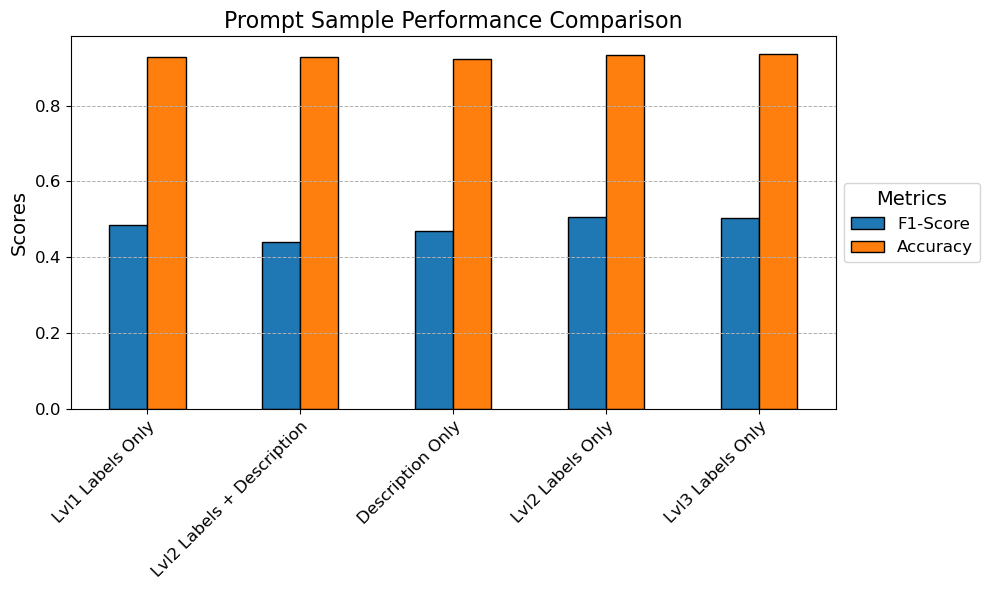

In [252]:
# Plot
ax = df_prompt_comparison[['avg_sample_f1-score','avg_sample_hamming_acc']].plot(kind='bar', figsize=(10, 6), edgecolor='black')

# Title and labels
plt.title('Prompt Sample Performance Comparison', fontsize=16)
plt.ylabel('Scores', fontsize=14)

# Customize ticks
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for both x and y axis for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, which='both')

# Add legend with title
plt.legend(title='Metrics', fontsize=12, title_fontsize=14, labels=['F1-Score', 'Accuracy'], loc='center left', bbox_to_anchor=(1.0, 0.5))

# Show the plot
plt.tight_layout()
plt.show()

## Test Chat GPT 4

In [185]:
#deployment_name = 'gpt-35-turbo' 
deployment_name = 'gpt-4-preview'
api_version = '2023-12-01-preview' # this might change in the future
client = AzureOpenAI( api_key=api_key, api_version=api_version, base_url=f"{api_base}/openai/deployments/{deployment_name}" )

In [187]:
from tqdm.notebook import tqdm
prompt_5_accuracy = []
prompt_5_targets = []
prompt_5_outputs = []

import time
start = time.time()

counter = 0
for test_text in tqdm(df_sample_['Web-Text']):
    
    prompt = f"""
                Angesichts der folgenden beschreibenden Inhalte aus verschiedenen Videos, klassifizieren Sie bitte jeden Ausschnitt, indem Sie bis zu zwei relevante Tags aus der bereitgestellten Tag-Liste zuweisen. Wählen Sie ein Tag, wenn es eindeutig am relevantesten ist, oder zwei Tags, wenn zwei Themen gleichermaßen prominent sind. Die Tags sollten die Hauptthemen des Textes genau widerspiegeln und zum Portfolio eines öffentlich-rechtlichen Senders passen.

                Die Tags und ihre zugehörigen Schlüsselwörter sind in der folgenden Tabelle beschrieben:

                | Tag | Schlüsselwörter |
                |:----|:----------------|
                | ARBEIT. | Arbeit, Arbeitnehmer, Arbeitsbedingung, Arbeitsrecht, Arbeitskonflikt, Arbeitslosigkeit, Arbeitsmarkt, Arbeitsvermittlung, Beruf, Einkommen, Gastarbeiter, Heimarbeit, Kinderarbeit, Karriere, Pensionierung, Schwarzarbeit, Sozialpartnerschaft |
                | BILDUNG. | Berufsbildung, Bildung, Eltern, Erwachsenenbildung, Erziehung, Hochschule, Höhere Fachschule, Fachmittelschule, Gymnasium, Kindergarten, Lehrer, Heil- und Sonderpädagogik, Primarschule, Privatschule, Schule, Schüler, Schulinhalt, Schulreform, Sekundarschule, Stipendium, Sportschule, Studierende |
                | ENERGIE. | Atomenergie, Brennstoff, Elektrizität, Energie, Energieverbrauch, Energietransport, Energiespeicher, Energiepolitik, Erneuerbare Energie, Fossile Energie, Kraftwerk, Staudamm |
                | FREIZEIT. | Alpinismus, Badeanstalt, Breitensport, Denksport, Ferien, Freizeit, Freizeitgarten, Freizeittanz, Geselligkeit, Glücksspiel, Hobby, Jahrmarkt, Nachtleben, Spielen, Sportanlage, Sportgerät, Tourismus, Verein, Wandern |
                | GESCHICHTE. | Geschichte, Geschichte-Früheste, Geschichte-Alte, Geschichte-Mittelalter, Geschichte-Neuere, Geschichte-Neueste |
                | GESUNDHEIT. | Alternativmedizin, Arzt, Drogenpolitik, Ernährung, Gesundheit, Gesundheitswesen, Hygiene, Krankenversicherung, Krankheit, Kur, Medikament, Medizin, Medizinische Forschung, Patientenrecht, Psychiatrie, Rettungswesen, Schwangerschaft, Sucht, Zahnmedizin |
                | GEWERBE. | Autogewerbe, Baugewerbe, Detailhandel, Dienstleistung, Gartenbau, Gastgewerbe, Getränk, Gewerbe, Handwerk, Haustechnik, Immobilienhandel, Kochen, Lebensmittelbranche, Logistik, Möbelbranche, Reiseunternehmen, Sicherheitsbranche |
                | INDUSTRIE. | Autoindustrie, Bergbau, Chemieindustrie, Computerindustrie, Druckindustrie, Flugzeugindustrie, Industrie, Industriestandort, Maschinenindustrie, Metallindustrie, Papierindustrie, Pharmaindustrie, Rohstoff, Rüstungsindustrie, Schiffsbau, Schuhindustrie, Sportartikelindustrie, Tabakindustrie, Textilindustrie, Uhrenindustrie, Unterhaltungselektronik |
                | JUSTIZ. | Bürgerrecht, Eigentumsrecht, Gericht, Gesetz, Internationales Recht, Justiz, Meinungsfreiheit, Menschenrecht, Ombudsstelle, Persönlichkeitsschutz, Personendokument, Strafrecht, Strafverfahren, Strafvollzug, Strafvollzugsanstalt, Urheberrecht, Wettbewerbsrecht, Zivilrecht |
                | KULTUR. | Architektur, Ausstellung, Denkmal, Design, Film, Fotografie, Gedächtnisinstitution, Kino, Kultur, Kulturpolitik, Kulturförderung, Kulturzentrum, Kunst, Literatur, Mode, Musik, Sprache und Schrift, Tanz, Theater, Unterhaltungsbranche |
                | LANDWIRTSCHAFT. | Agrarpolitik, Berglandwirtschaft, Biologische Landwirtschaft, Fischerei, Fleischproduktion, Forstwirtschaft, Jagd, Landwirtschaft, Landwirtschaftsprodukt, Milch, Nutzpflanze, Tierhaltung, Veterinärmedizin, Weinbau |
                | MEDIEN UND KOMMUNIKATION. | Fernsehen, Internet, Journalismus, Medien, Medien und Kommunikation, Medien- und Multimedia-Unternehmen, Medienpolitik, Nachrichtenagentur, Post, Presse, Radio, Satellitenkommunikation, Telekommunikation, Verlag, Video, Zensur |
                | MENSCH. | Alltag, Alter, Asylpolitik, Ausländer, Auslandschweizer, Behinderung, Bevölkerung, Diskriminierung, Ehe, Ethnie, Familie, Flüchtling, Frau, Frauenaktivität, Gesellschaftsform, Gesellschaftsfragen, Grenzgänger, Haushalt, Jugend, Kind, Konkubinat, Liebe, Mann, Mensch, Migration, Minderheit, Randständige, Seelisches, Sexualität, Sterben, Verhalten, Wohnen |
                | MILITÄR. | Internationales Militärbündnis, Kriegsvorsorge, Militär, Militäranlage, Militärausgaben, Militärdienst, Militärjustiz, Militärschau, Rüstung, Schweizergarde, Truppengattung, Truppenstationierung, Waffe, Militär, Waffe, Privat, Zivildienst, Zivilschutz |
                | PORTRÄT. | Porträt Geografie, Porträt Körperschaften, Porträt Personen, Porträt Thema |
                | RELIGION. | Christentum, Christliche Kirche, Glaube, Gott, Mission, Nichtchristliche Religion, Ökumene, Religiöse Schriften, Religiöser Fundamentalismus, Religiöse Sondergemeinschaft, Religion, Spiritualität |
                | SENSATION. | Affäre, Auszeichnung, Brand, Erfindung, Expedition, Explosion, Kuriosa, Prominenz, Sensation, Showbusiness, Unfall |
                | SOZIALES. | Altersvorsorge, Armut, Demoskopie, Feier, Heim, Hilfswerk, Humanitäre Hilfe, Lebensstandard, Reichtum, Sozialarbeit, Soziale Bewegung, Soziales, Sozialhilfe, Sozialpolitik, Sozialversicherung, Protest, Vormundschaft, Zukunft |
                | STAAT UND POLITIK. | Abstimmung, Amtsausübung, Aussenpolitik, Bund, Europäische Integration, Feuerwehr, Finanzen, Frieden, Gemeinde, Gewaltentrennung, Gleichstellung, Grenze, Heimat, Ideologie, Initiative, Innenpolitik, Internationale Organisation, Kanton, Krieg, Landesausstellung, Lobbyismus, Mass, Neutralität, Ost-West, Parlament, Politische Gruppierung, Polizei, Referendum, Reformprozess, Regierung, Regionalismus, Siedlungspolitik, Staat und Politik, Staatsbetrieb, Staatsfeier, Staatsform, Staatssicherheit, Staatszugehörigkeit, Steuer, Subvention, Umsturz, Unruhen, Verfassung, Verwaltung, Wahl, Wiedergutmachung, Weltausstellung, Widerstandsbewegung, Zoll, Zwischenstaatlicher Konflikt |
                | STRAFTAT. | Bombenalarm, Doping, Drogendelikt, Ehrendelikt, Eigentumsdelikt, Fälschung, Gewalt gegen Personen, Korruption, Kriminelle Vereinigung, Kriegsverbrechen, Politische Verbrechen, Sachbeschädigung, Sexualdelikt, Straftat, Spionage, Tötungsdelikt, Verbrechensverhütung, Verkehrsdelikt, Wirtschaftskriminalität |
                | TECHNIK. | Automatisierung, Computertechnik, Digitalisierung, Elektrotechnik, Präzisionsinstrument, Raumfahrttechnik, Software, Technik, Überwachungstechnik, Werkstoff, Werkzeug |
                | UMWELT. | Abfall, Atom, Atommüll, Boden, Gewässer, Giftstoff, Heimatschutz, Klima, Lärm, Landschaft, Luft, Naturkatastrophe, Raumplanung, Recycling, Schädlingsbekämpfung, Stadt, Tier, Umwelt, Umweltschutz, Wald, Wasser, Wetter |
                | VERKEHR. | Alpentransversale, Auto, Autobahn, Bahn, Bahnanlage, Bus, Bergbahn, Brücke, E-Fahrzeug, Fahrplan, Fahrpreis, Fahrrad, Fluggesellschaft, Flughafen, Flugzeug, Fussgänger, Güterverkehr, Historische Verkehrsmittel, Luftverkehr, Motorrad, Nahverkehr, Öffentlicher Verkehr, Parken, Pendlen, Raumfahrt, Schifffahrt, Strassenbau und Unterhalt, Strassenverkehr, Tram, Tunnel, Verkehr, Verkehrsverband, Verkehrsverbund, Verkehrspolitik |
                | VOLKSKULTUR. | Brauchtum, Brauchtumssport, Feiertag, Jahreszeit, Zunft |
                | WIRTSCHAFT. | Arbeitgeber, Aussenwirtschaft, Betriebsänderung, Bodenmarkt, Finanzbranche, Geld, Gold, Handel, Investition, Kapitalmarkt, Kartell, Konjunktur, Konkurs, Konsum, Kredit, Preisniveau, Selbstständigkeit, Sponsoring, Unternehmen, Unternehmenskonzentration, Versicherungsbranche, Währung, Weltwirtschaft, Werbung, Wirtschaft, Wirtschaftspolitik, Wirtschaftsstatistik, Zentralbank |
                | WISSENSCHAFT. | Archäologie, Astronomie, Biologie, Chemie, Ethnologie, Geisteswissenschaft, Genetik, Geografie, Geologie, Geschichtswissenschaft, Grenzwissenschaft, Informatik, Kartografie, Literaturwissenschaft, Mathematik, Meteorologie, Naturwissenschaft, Paläontologie, Philosophie, Physik, Politologie, Psychologie, Rechtswissenschaft, Religionswissenschaft, Soziologie, Sportwissenschaft, Sprachwissenschaft, Theologie, Wirtschaftswissenschaft, Wissenschaft |

                Text zum Klassifizieren: '{test_text}'

                Ihre Aufgabe ist es, den Ausschnitt zu lesen und die am besten passenden Tags zuzuweisen, die den Inhalt am besten widerspiegeln, unter Berücksichtigung ihrer Relevanz für den öffentlich-rechtlichen Rundfunk und die Informationen in der Tabelle. 
                Geben Sie nur die Tags als Python-Liste aus.
            """
    
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "Sie sind ein hilfreicher Assistent, der dem Redaktionsteam des öffentlich-rechtlichen Rundfunks hilft, zentrale Themen aus beschreibenden Videotexten zu extrahieren."},
                {"role": "user", "content": prompt}
            ]
        )
    except Exception as e:
        continue
        print(f"API Error: {test_text}, Error: {e}")
    
     # Transfer ChatGPT output to One-Hot encoded list
    try:
        output_tags = response.choices[0].message.content
        one_hot_encoded_tags = match_and_encode_tags(output_tags, label_names)
        df_text = df[df['Web-Text'] == test_text].reset_index(drop=True)   
    except Exception as e:
        print(f"Error processing text:{e}")
        print(response.choices[0].message.content)
        continue
    
    prompt_5_outputs.append(one_hot_encoded_tags)
    prompt_5_targets.append(df_text['Categories'][0])    
    # Compute Accuracy on the fly
    match_percent = sum(i==j for i,j in zip(df_text['Categories'][0],one_hot_encoded_tags))/len(one_hot_encoded_tags)
    prompt_5_accuracy.append(match_percent)
    
    # Print some of the Answers
    if counter % 15 == 0:
        # Show the Answer
        visualisation_encodings(response, test_text, df_text)
    counter += 1
    

end = time.time()
print(end - start)


  0%|          | 0/300 [00:00<?, ?it/s]

Text: Türkei stimmt für Schwedens Nato-Beitritt
Das türkische Parlament hat den Beitritt Schwedens in die Nato gebilligt. Nun muss Präsident Erdogan das sogenannte Beitrittsprotokoll noch unterschreiben, was als so gut wie sicher gilt.
Output Tags (incorrect format): ```python
["STAAT UND POLITIK", "MILITÄ
Real Tags: ['MILITÄR.']

Text: Wie funktionieren Wetten?
In einem Beitrag werden die diversen möglichen Wetten aufgezeigt, die auf jedes Spiel eingegangen werden können. Zudem wird klar, dass man auf irgendein Spiel setzen kann  ganz egal, wo es stattfindet. Roger Hegi betont, dass Wetten auf die manipulierten Schweizer Spiele vor allem in Asien platziert wurden. Markus Stähli begründet, wieso alle Thuner Spieler eine Erklärung unterschreiben mussten, dass sie nicht betrogen haben.
Output Tags (incorrect format): ["FREIZEIT.", "JUSTIZ."]
Real Tags: ['FREIZEIT.', 'MEDIEN UND KOMMUNIKATION.', 'STRAFTAT.']

Text: Langlauf und Tourenskifahren sind die besten Kalorien-Killer
Die Hauptmot

933.2201433181763


In [253]:
results_5 = list(precision_recall_fscore_support(prompt_5_targets, prompt_5_outputs, average='samples'))
results_5.append(hamming_accuracy(np.array(prompt_5_targets),np.array(prompt_5_outputs)))
results_5

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6153846153846154,
 0.5370680044593088,
 0.5486064659977703,
 None,
 0.934525340879856]

In [254]:
np.mean(prompt_5_accuracy)

0.9345253408798558

In [255]:
hamming_accuracy(np.array(prompt_5_targets),np.array(prompt_5_outputs))

0.934525340879856

In [256]:
from sklearn.metrics import classification_report

report = classification_report(prompt_5_targets, prompt_5_outputs, target_names=label_names)
print(report)

                           precision    recall  f1-score   support

                  ARBEIT.       0.40      0.67      0.50        12
                 BILDUNG.       0.60      0.67      0.63         9
                 ENERGIE.       1.00      0.74      0.85        19
                FREIZEIT.       0.58      0.46      0.51        24
              GESCHICHTE.       0.35      0.60      0.44        10
              GESUNDHEIT.       0.92      0.64      0.75        36
                 GEWERBE.       0.75      0.20      0.32        30
               INDUSTRIE.       0.56      0.29      0.38        17
                  JUSTIZ.       0.45      0.65      0.54        23
                  KULTUR.       0.64      0.77      0.70        35
          LANDWIRTSCHAFT.       0.75      0.36      0.49        25
MEDIEN UND KOMMUNIKATION.       0.50      0.20      0.29        25
                  MENSCH.       0.57      0.30      0.39        27
                 MILITÄR.       0.88      0.37      0.52     

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [257]:
df_prompt_comparison.loc['Lvl2 Labels Only GPT4', ['avg_sample_precision','avg_sample_recall','avg_sample_f1-score','avg_sample_hamming_acc','time_seconds','version']] = results_5[0:3] + results_5[-1:] + [933.2201433181763, 'chatGPT 4']

In [271]:
df_prompt_comparison['time_minutes'] = df_prompt_comparison['time_seconds']/30/60

In [272]:
df_prompt_comparison

,avg_sample_precision,avg_sample_recall,avg_sample_f1-score,avg_sample_hamming_acc,time_seconds,version,time_minutes
Lvl1 Labels Only,0.582215,0.456655,0.484004,0.928369,628.802197,chatGPT 3,0.349335
Lvl2 Labels + Description,0.534091,0.409722,0.439015,0.927593,637.060373,chatGPT 3,0.353922
Description Only,0.538031,0.460011,0.470358,0.922819,631.780827,chatGPT 3,0.350989
Lvl2 Labels Only,0.607023,0.476867,0.505463,0.931953,633.959113,chatGPT 3,0.352200
Lvl3 Labels Only,0.634680,0.460999,0.504265,0.935638,633.697094,chatGPT 3,0.352054
Lvl2 Labels Only GPT4,0.615385,0.537068,0.548606,0.934525,933.220143,chatGPT 4,0.518456


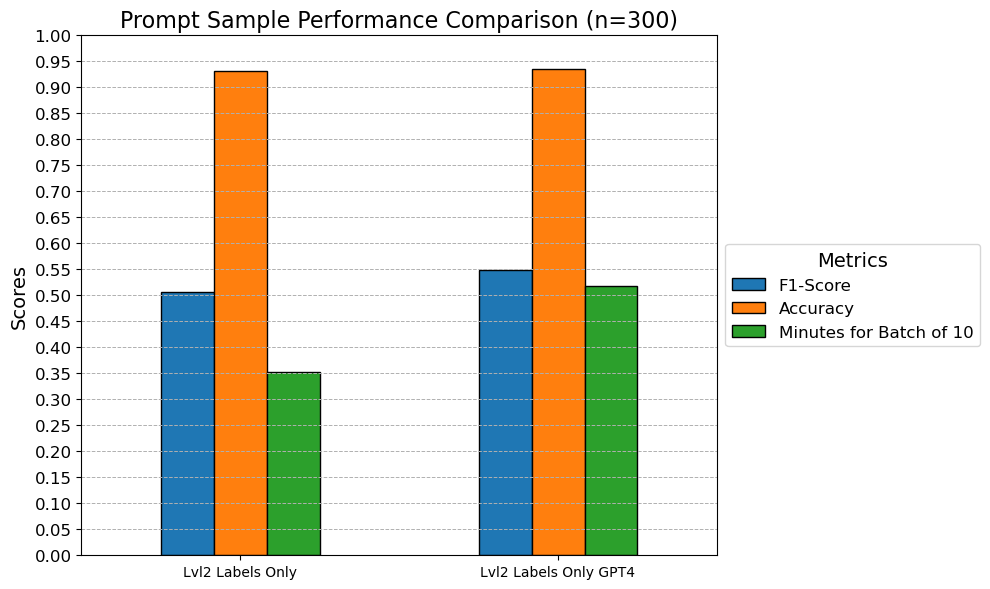

In [279]:
# Plot
ax = df_prompt_comparison[['avg_sample_f1-score','avg_sample_hamming_acc', 'time_minutes']].iloc[[3,5], :].plot(kind='bar', figsize=(10, 6), edgecolor='black')

# Title and labels
plt.title('Prompt Sample Performance Comparison (n=300)', fontsize=16)
plt.ylabel('Scores', fontsize=14)

# Customize ticks
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=12)

# Add more y-ticks for better readability
ax.set_yticks([i * 0.05 for i in range(0, 21)])  # y-ticks from 0 to 1 with step of 0.05

# Add gridlines for both x and y axis for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, which='both')

# Add legend with title
plt.legend(title='Metrics', fontsize=12, title_fontsize=14, labels=['F1-Score', 'Accuracy', 'Minutes for Batch of 10'], loc='center left', bbox_to_anchor=(1.0, 0.5))

# Show the plot
# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()